<div style="text-align:center"> 
    <p style="font-size: 50px; margin-bottom: 0">Open Cluster Characterisation - M67</p>
    <p style="font-size: 20px; font-style: italic">ASTR 511 HW2 - Tom Wagg</p>
    <img src="M67_scienceblogsdotcom.jpeg" height="300px" style="border-radius: 100%">
</div>

Author: Tom Wagg

Collaborators: Just lonely old me this time

In [198]:
import time
import numpy as np
import pandas as pd
pd.options.display.max_columns = None

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format = "retina"
plt.style.use("dark_background")

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from sklearn.mixture import GaussianMixture
from isochrones.mist import MISTIsochroneGrid
from isochrones.mist.bc import MISTBolometricCorrectionGrid

import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
Gaia.ROW_LIMIT = -1

# Part 1: Isolate cluster members
## Perform a Cone Search around the target

To start, we'll do a simple search around the target with a radius of 1 degree. (I'm also going to be ambiguous and say target a lot so it's easy to edit the notebook if I switch clusters haha)

In [199]:
notebook_start = time.time()

In [200]:
coord = SkyCoord(ra="08h51m03s", dec=11.49, unit=(u.degree, u.degree), frame='icrs')
radius = 1 * u.deg
j = Gaia.cone_search_async(coord, radius)

INFO: Query finished. [astroquery.utils.tap.core]


In [201]:
r = j.get_results()
r = r.to_pandas().set_index("source_id")

In [202]:
# didn't use this in the end but tracking the interesting columns for me
columns=["dist", "source_id", "ra", "dec", "ra_error", "dec_error",
         "parallax", "parallax_error", "pmra", "pmra_error", "pmdec", "pmdec_error",
         "phot_g_mean_mag", "phot_bp_mean_mag", "phot_rp_mean_mag", "a_g_val"]

In [203]:
r

solution_id                  DESIGNATION  \
source_id                                                              
598889556854572672  1635721458409799680  Gaia DR2 598889556854572672   
598889552564701312  1635721458409799680  Gaia DR2 598889552564701312   
598889449480994944  1635721458409799680  Gaia DR2 598889449480994944   
598889453776193536  1635721458409799680  Gaia DR2 598889453776193536   
598889213257785344  1635721458409799680  Gaia DR2 598889213257785344   
...                                 ...                          ...   
608029934456011904  1635721458409799680  Gaia DR2 608029934456011904   
605030501094914816  1635721458409799680  Gaia DR2 605030501094914816   
598744902356568192  1635721458409799680  Gaia DR2 598744902356568192   
604610139760778496  1635721458409799680  Gaia DR2 604610139760778496   
605011667665148032  1635721458409799680  Gaia DR2 605011667665148032   

                    random_index  ref_epoch          ra  ra_error        dec  \
source_id                                                                      
598889556854572672    1176460461     2015.5  132.762456  0.039452  11.495085   
598889552564701312     939420882     2015.5  132.756219  1.221686  11.493655   
598889449480994944     299968321     2015.5  132.752334  0.969877  11.486227   
598889453776193536     749852865     2015.5  132.749228  1.894279  11.487162   
598889213257785344    1533612818     2015.5  132.746308  0.227897  11.480005   
...                          ...        ...         ...       ...        ...   
608029934456011904     593083375     2015.5  132.719511  8.476778  12.489013   
605030501094914816    1353895459     2015.5  133.611420  0.036462  12.046022   
598744902356568192    1688918089     2015.5  132.015359  0.042111  10.809866   
604610139760778496    1496127150     2015.5  133.610799  0.110960  10.935392   
605011667665148032    1285643619     2015.5  133.119568  2.395854  12.426996   

                    dec_error  parallax  parallax_error  parallax_over_error  \
source_id                                                                      
598889556854572672   0.035029  0.782290        0.056015            13.965704   
598889552564701312   1.171564 -0.103058        1.686537            -0.061106   
598889449480994944   0.840157  3.825357        1.225824             3.120640   
598889453776193536   1.388538       NaN             NaN                  NaN   
598889213257785344   0.179379  1.318261        0.293374             4.493452   
...                       ...       ...             ...                  ...   
608029934456011904   8.422663       NaN             NaN                  NaN   
605030501094914816   0.021807  0.891515        0.043565            20.463840   
598744902356568192   0.040707  1.830523        0.047488            38.547180   
604610139760778496   0.070778  1.274119        0.148750             8.565526   
605011667665148032   1.909075       NaN             NaN                  NaN   

                         pmra  pmra_error      pmdec  pmdec_error  \
source_id                                                           
598889556854572672  -2.234006    0.118945   1.268996     0.119216   
598889552564701312  -1.034997    3.147085  -4.892142     2.662119   
598889449480994944 -14.772357    2.131818 -15.708994     2.144506   
598889453776193536        NaN         NaN        NaN          NaN   
598889213257785344   0.502624    0.502957   6.348940     0.452478   
...                       ...         ...        ...          ...   
608029934456011904        NaN         NaN        NaN          NaN   
605030501094914816  -1.980217    0.079061  -8.205994     0.054794   
598744902356568192  -9.348063    0.081969  -9.280384     0.074242   
604610139760778496  -5.382062    0.240326 -10.452088     0.156673   
605011667665148032        NaN         NaN        NaN          NaN   

                    ra_dec_corr  ra_parallax_corr  ra_pmra_corr  \
source_id                                   

### Plot out the proper motions
Let's plot out the proper motions with a coarse hexbin just to get a sense of what we're working with

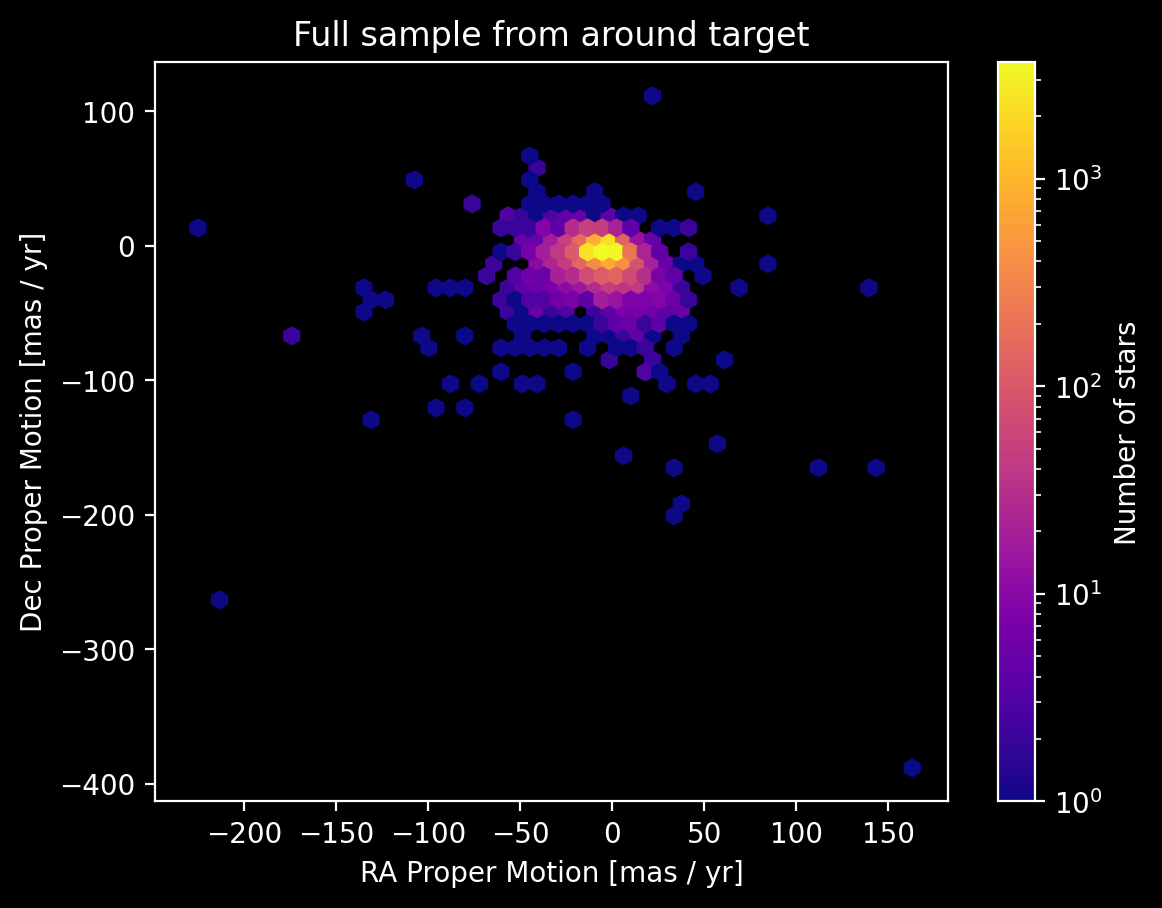

In [204]:
hb = plt.hexbin(r["pmra"], r["pmdec"], gridsize=50, bins="log", cmap="plasma")
plt.colorbar(hb, label="Number of stars")
plt.xlabel("RA Proper Motion [mas / yr]")
plt.ylabel("Dec Proper Motion [mas / yr]")
plt.title("Full sample from around target")
plt.show()

## Simple quality cuts
Now we can apply some simple quality cuts. For this I have just applied
- Ensure there are no NaNs (basically avoid bad measurements I think?)
- Fix a good parallax/parallax error radius to keep only the ones with a good measurement
- Restrict the proper motion to reasonably slow velocities to get rid of outliers

In [205]:
no_nan_columns=["ra", "dec", "ra_error", "dec_error", "parallax", "parallax_error", "pmra", "pmra_error",
                "pmdec", "pmdec_error", "phot_g_mean_mag", "phot_bp_mean_mag", "phot_rp_mean_mag"]
not_nan_index = r.dropna(axis=0, subset=no_nan_columns).index

In [206]:
not_nan = np.isin(r.index, not_nan_index)
good_parallax = (r["parallax"] / r["parallax_error"]) > 5
not_too_fast = (np.abs(r["pmra"]) < 30) & (np.abs(r["pmdec"]) < 30)

quality_cut = not_nan & good_parallax & not_too_fast
len(r), len(r[quality_cut])

(19580, 5240)

This reduces the data to about a quarter of its original size

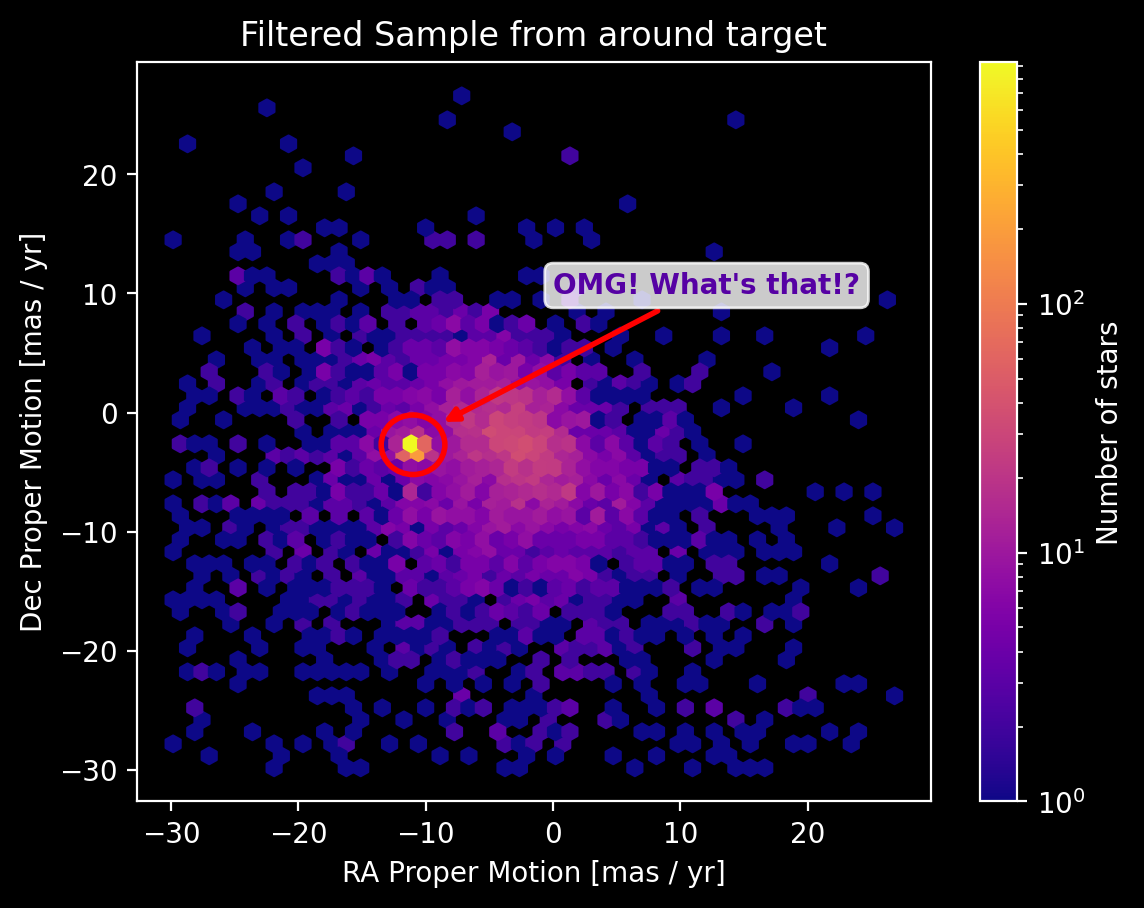

In [207]:
hb = plt.hexbin(r["pmra"][quality_cut], r["pmdec"][quality_cut], gridsize=50, bins="log", cmap="plasma")
plt.colorbar(hb, label="Number of stars")
plt.xlabel("RA Proper Motion [mas / yr]")
plt.ylabel("Dec Proper Motion [mas / yr]")
plt.title("Filtered Sample from around target")
plt.gca().add_artist(plt.Circle((-11, -2.7), 2.5, facecolor="none", edgecolor="red", lw=2))
plt.annotate("OMG! What's that!?", xy=(-9, -1), xytext=(0, 10), color=plt.get_cmap("plasma")(0.15),
             bbox=dict(boxstyle="round", color="white", alpha=0.8),
             arrowprops=dict(arrowstyle="-|>", color="red", lw=2), fontweight="bold")
plt.show()

Look! We can see a cluster!!! So cool :D Now let's go identify which stars belong to it properly.

## Apply Gaussian Mixture Model to isolate cluster stars
Shoutout to Andy C and Stephen for teaching me how to do this in their class last year

The general plan here:
1. Fit a series of GMMs with a range of different `n_components`
2. Pick the one with the lowest BIC
3. For chosen model, predict the probability that each star belongs to the cluster (I'm assuming the cluster is the most compact of the different Gaussians)
4. ...Profit?

At first I did this just using the proper motions but now I've thrown in the sky position and parallax too since scikit-learn is nice and that was a one line change :D

In [208]:
# I stole this from an example in the scikit-learn docs which I have now lost
# it plots the ellipses representing the gaussians that are fit roughly
def make_ellipses(gmm, ax):
    for n in range(gmm.n_components):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color=f"C{n + 1}"
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.25)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")

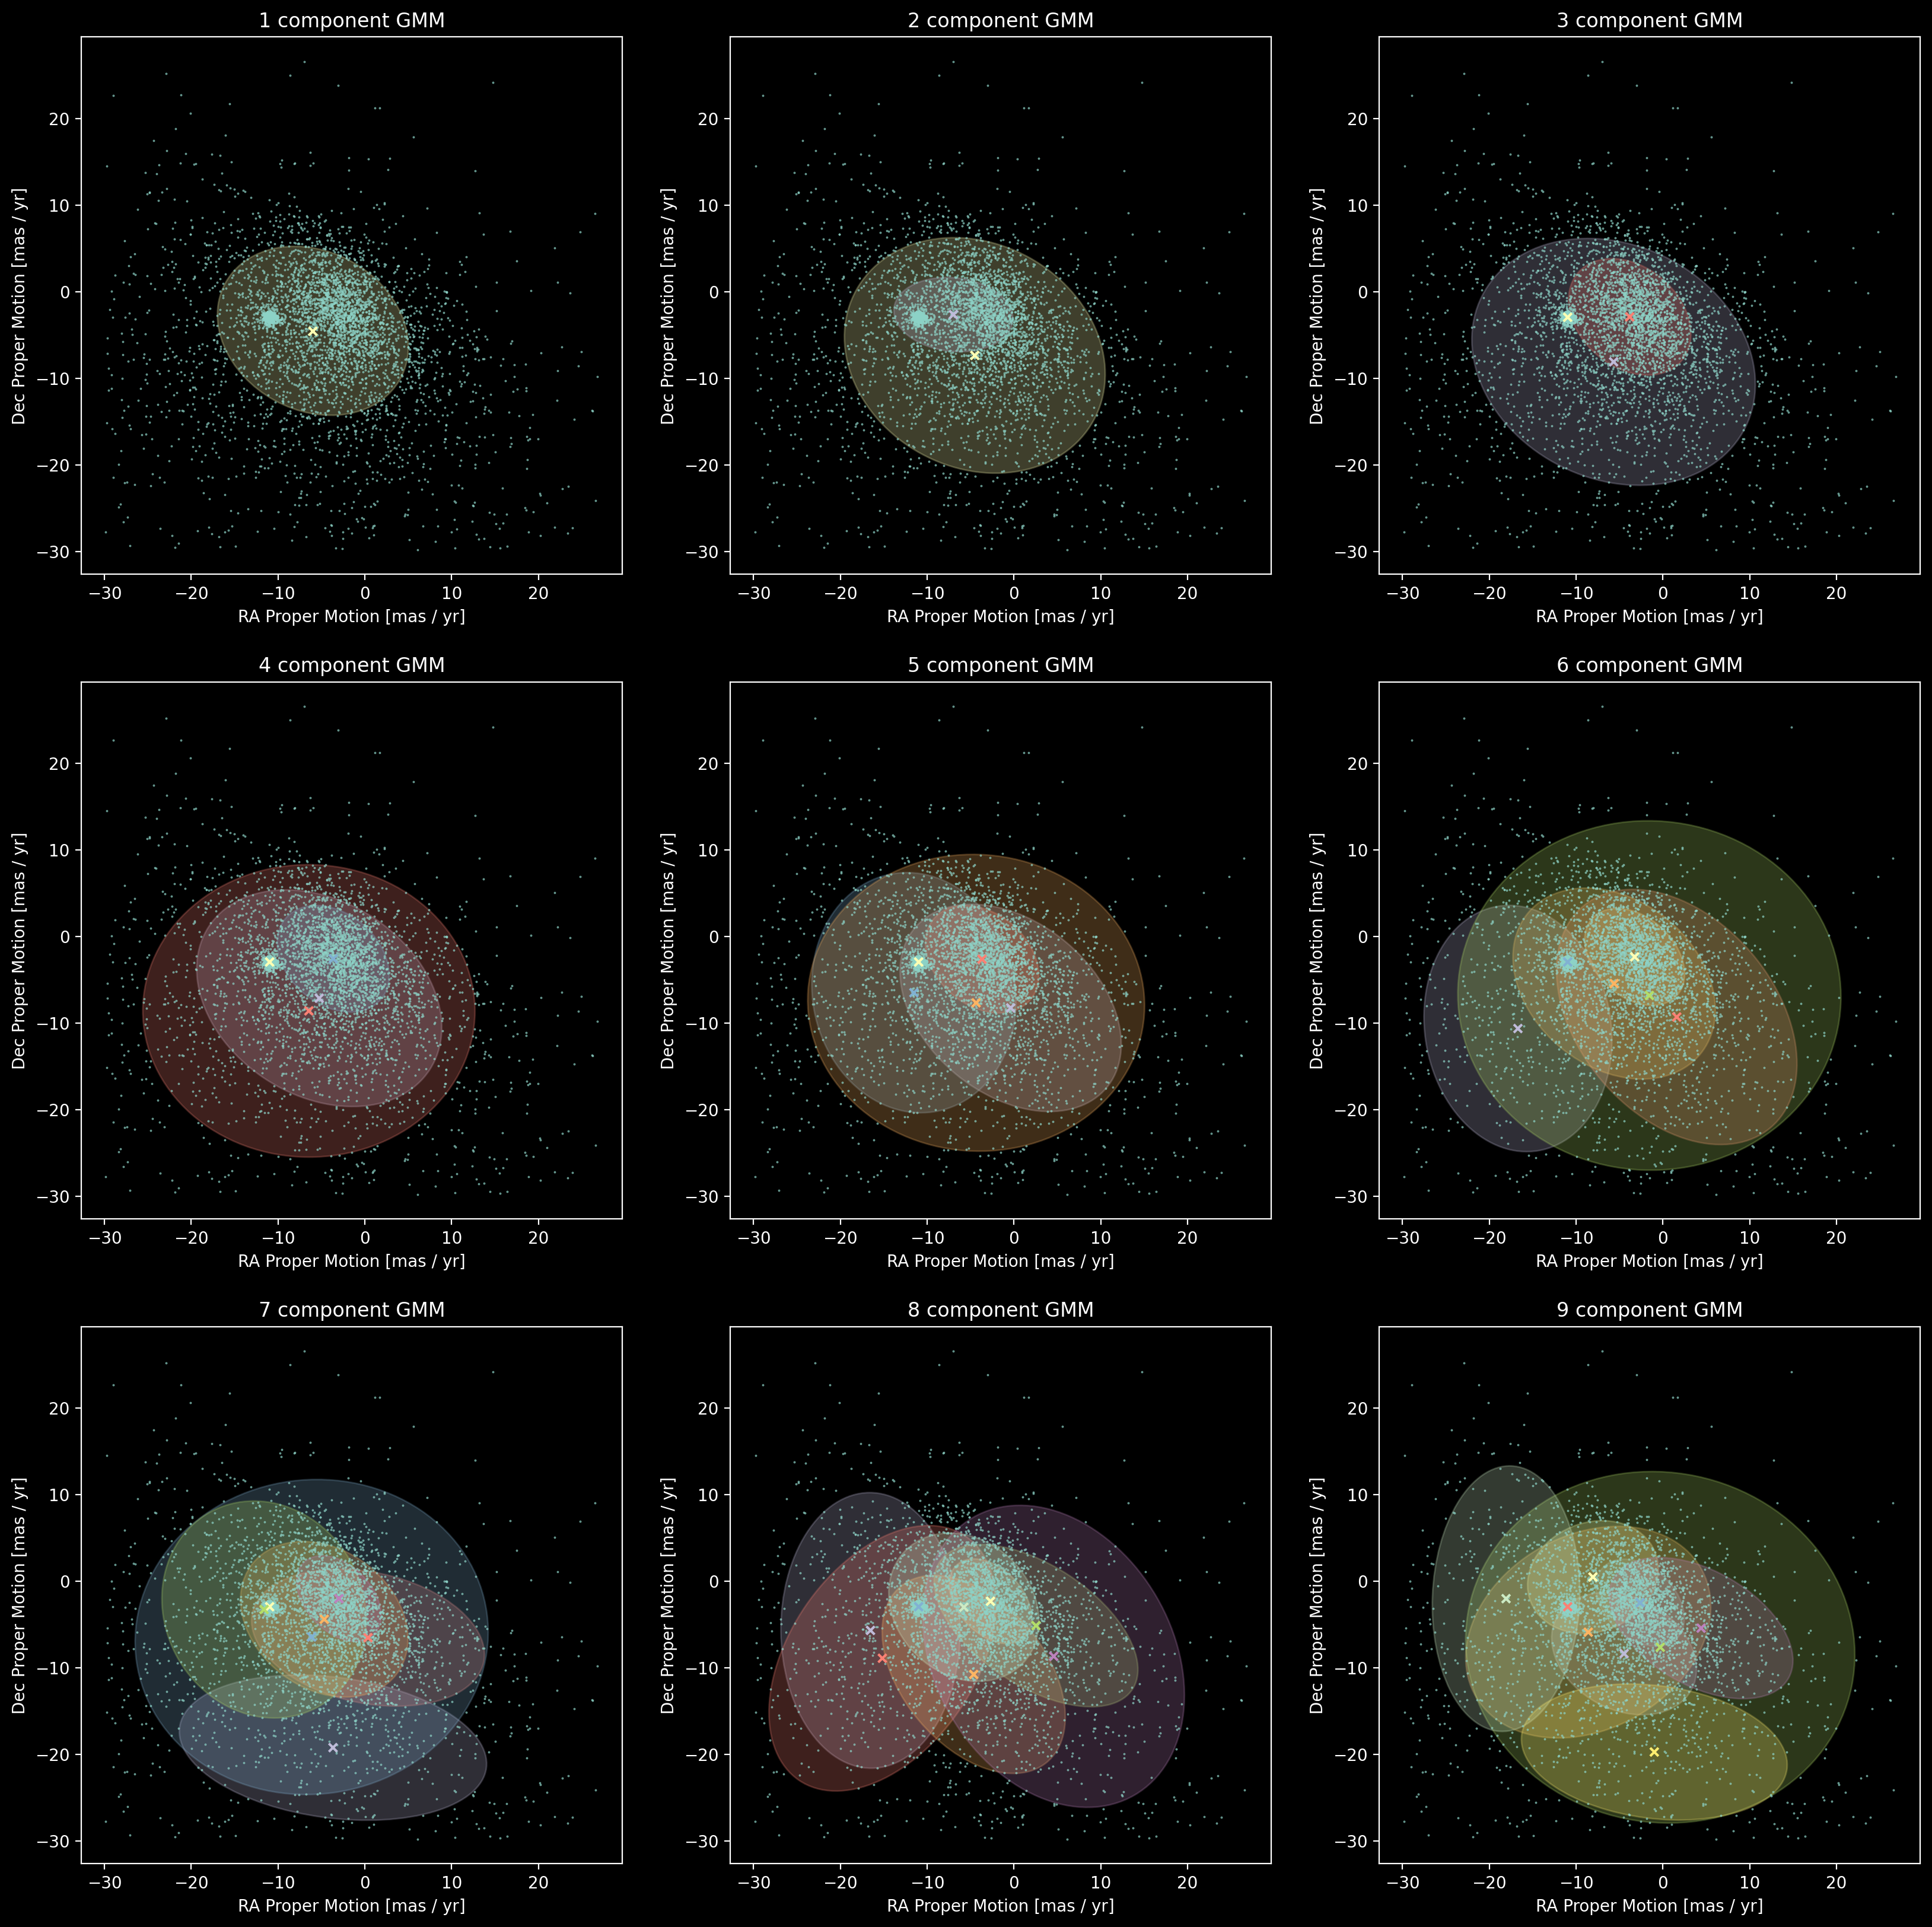

In [209]:
n_components_list = range(1, 10)

fig, axes = plt.subplots(3, 3, figsize=(20, 20))
flat_axes = axes.ravel()

bics = [None for i in n_components_list]
mixes = [None for i in n_components_list]
X = r[["pmra", "pmdec", "parallax", "ra", "dec"]][quality_cut].values
for i, n_components in enumerate(n_components_list):
    mixes[i] = GaussianMixture(n_components=n_components)
    mixes[i].fit(X)

    bics[i] = mixes[i].bic(X)

    make_ellipses(mixes[i], flat_axes[i])

    flat_axes[i].scatter(*X.T[:2, :], s=0.1)#, c=mix.predict(X))
    flat_axes[i].scatter(*mixes[i].means_.T[:2, :], s=25, marker="x",
                c=[f"C{j + 1}" for j in range(n_components)])
    flat_axes[i].set_title(f"{n_components} component GMM")


for ax in flat_axes:
    ax.set_xlabel("RA Proper Motion [mas / yr]")
    ax.set_ylabel("Dec Proper Motion [mas / yr]")

plt.show()

By eye we can see the cluster pop out as soon as we have a couple of components to our GMM - but which model is best? How many do we actually need? Time for a cheeky Bayesian Information Criterion test!

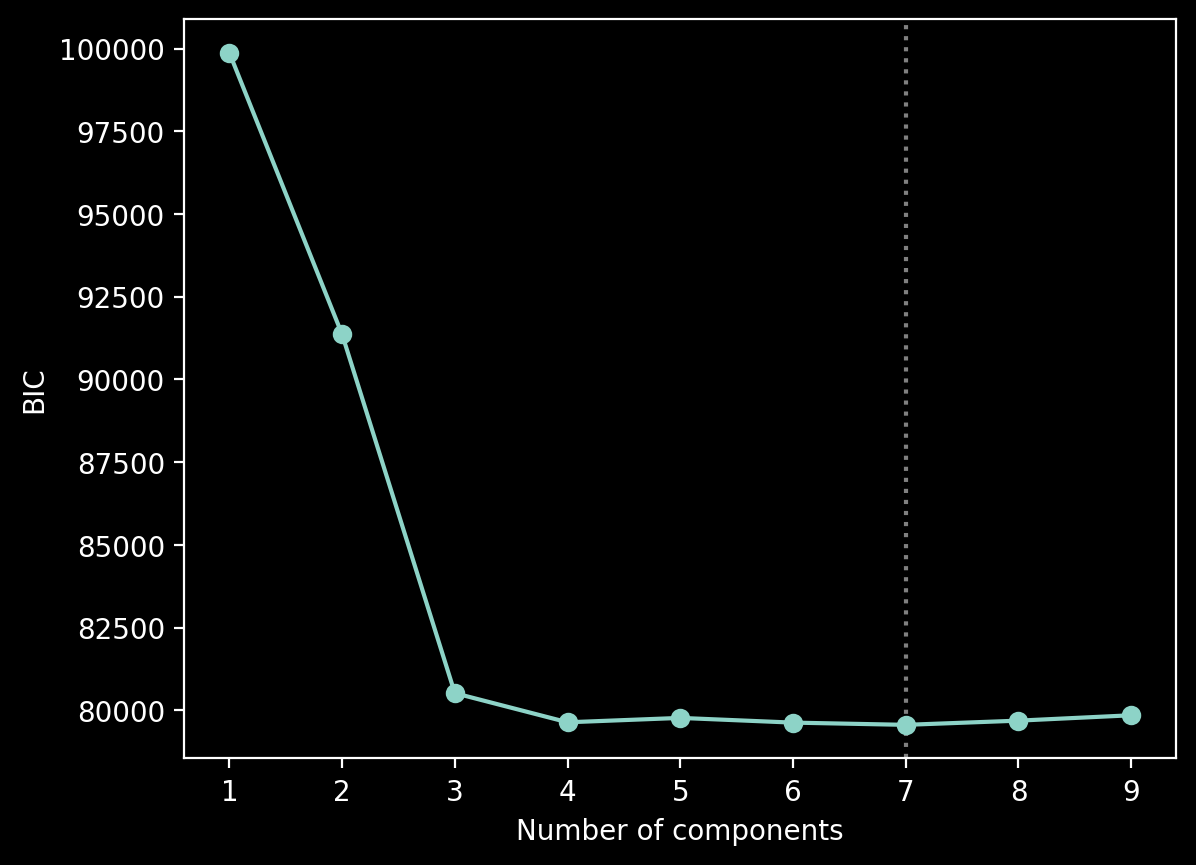

In [210]:
plt.plot(n_components_list, bics, marker="o")
plt.xlabel("Number of components")
plt.ylabel("BIC")
plt.axvline(n_components_list[np.argmin(bics)], color="grey", linestyle="dotted", zorder=-1)
plt.show()

So now we've found a best fitting mixture model, no need for more components. Great, now let's identify which of the components is our cluster (assuming that it is the smallest one)

#### Side note: Linear Algebra fun times (Finding the smallest n-dimensional component)

It took me a fair bit to work out to find the smallest component but it's fun so I wanted to write it down :D For 2D components it sort of makes sense conceptually. In this case each component will be some sort of ellipse with a different alignment and size described by its covariance matrix. The eigenvectors of this covariance matrix describe the direction that the major and minor axis of the ellipse are pointing, whilst the eigenvalues give you the size of each of those respective axes. The area of this ellipse is just $\pi a b$, or approximately just the product of the eigenvalues.

You can then extend this into n-dimensions and even though I'm going to visualise my 5D ellipse thing, the product of the eigenvalues seems to work as a good proxy for the space occupied by each component. A rare occasion on which I was actually able to apply some linear algebra haha.

In [211]:
best_mix = mixes[np.argmin(bics)]

ellipse_areas = [np.product(np.linalg.eigh(best_mix.covariances_[i])[0]) for i in range(best_mix.n_components)]
cluster_comp = np.argmin(ellipse_areas)

In [212]:
# get a probability that each star is part of the cluster
probs = best_mix.predict_proba(X)[:, cluster_comp]

Conservatively just say a start needs a 10% chance of being in the cluster to make it through our cut. Let's see how that looks

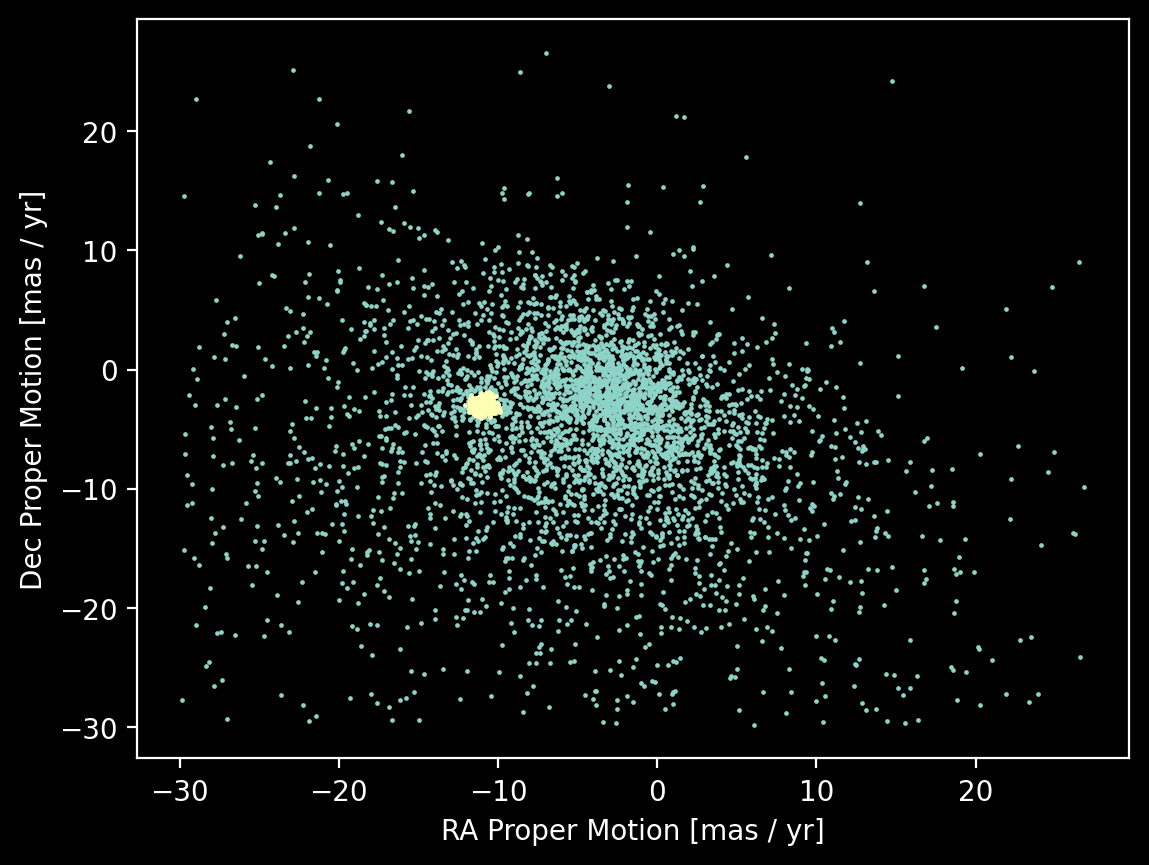

In [213]:
plt.scatter(*X.T[:2, :], s=0.5)
plt.scatter(*X[probs > 0.1].T[:2, :], s=0.5)
plt.xlabel("RA Proper Motion [mas / yr]")
plt.ylabel("Dec Proper Motion [mas / yr]")
plt.show()

Looking good! I see a cluster :D

# Part 2: Characterisation
Now let's start to explore what sort of a cluster this is!

In [214]:
cluster = r[quality_cut][probs > 0.9]
field = r[quality_cut][probs < 0.9]
cluster_strict = r[quality_cut][probs > 0.999]

## Initial Color-Magnitude Diagrams
As a first step, let's plot the CMD before and after the cut using a quick little function

In [215]:
# plot color-magnitude diagram(s) for a table of gaia sources
def plot_cmd(*gaia_table, colour_col=None, show=True, **kwargs):
    if colour_col:
        fig, ax = plt.subplots(figsize=(6.5, 9))
    else:
        fig, ax = plt.subplots(figsize=(5, 9))

    label_it = False

    for table in gaia_table:

        if isinstance(table, tuple):
            table, s, colour, label = table
            label_it = True
        else:
            s, colour, label = 0.25, None, None

        if "phot_g_mean_mag" in table.columns.values:
            bp, rp, G = "phot_bp_mean_mag", "phot_rp_mean_mag", "phot_g_mean_mag"
            isochrone = False
        else:
            bp, rp, G = "BP", "RP", "G"
            isochrone = True

        if isochrone:
            ax.plot(table[bp] - table[rp], table[G], zorder=-1, lw=1, marker="o", markersize=1,
                    color="grey" if colour is None else colour,
                    label="Isochrone" if label is None else label)
        elif colour_col is None:
            ax.scatter(table[bp] - table[rp], table[G], s=s, color=colour, label=label, **kwargs)
        else:
            scatter = ax.scatter(table[bp] - table[rp], table[G], s=0.25, c=np.nan_to_num(table[colour_col], nan=0.0), **kwargs)
            fig.colorbar(scatter, label=colour_col, fraction=0.2)

    ax.invert_yaxis()
    
    if label_it:
        ax.legend(loc="lower left")

    ax.set_xlabel(r"Colour, $G_{\rm BP} - G_{\rm RP}$")
    ax.set_ylabel(r"Magnitude, $G$")

    if show:
        plt.show()
    return fig, ax

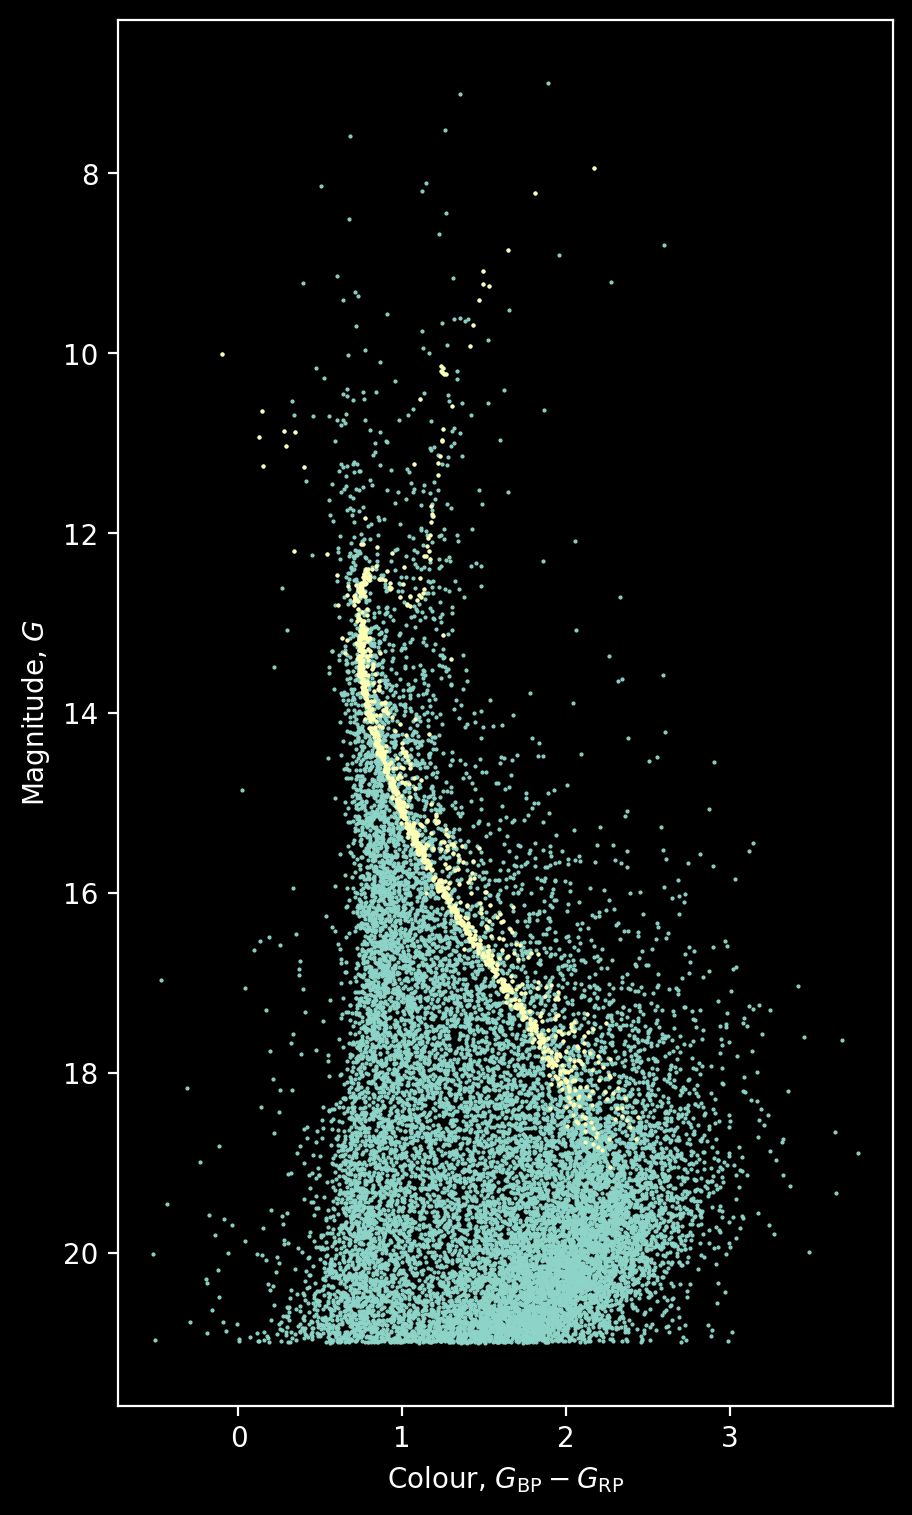

(<Figure size 500x900 with 1 Axes>,
 <AxesSubplot: xlabel='Colour, $G_{\\rm BP} - G_{\\rm RP}$', ylabel='Magnitude, $G$'>)

In [216]:
plot_cmd(r, cluster)

Look how far we've come! Much much cleaner. Here's the cluster CMD alone, coloured by the parallax

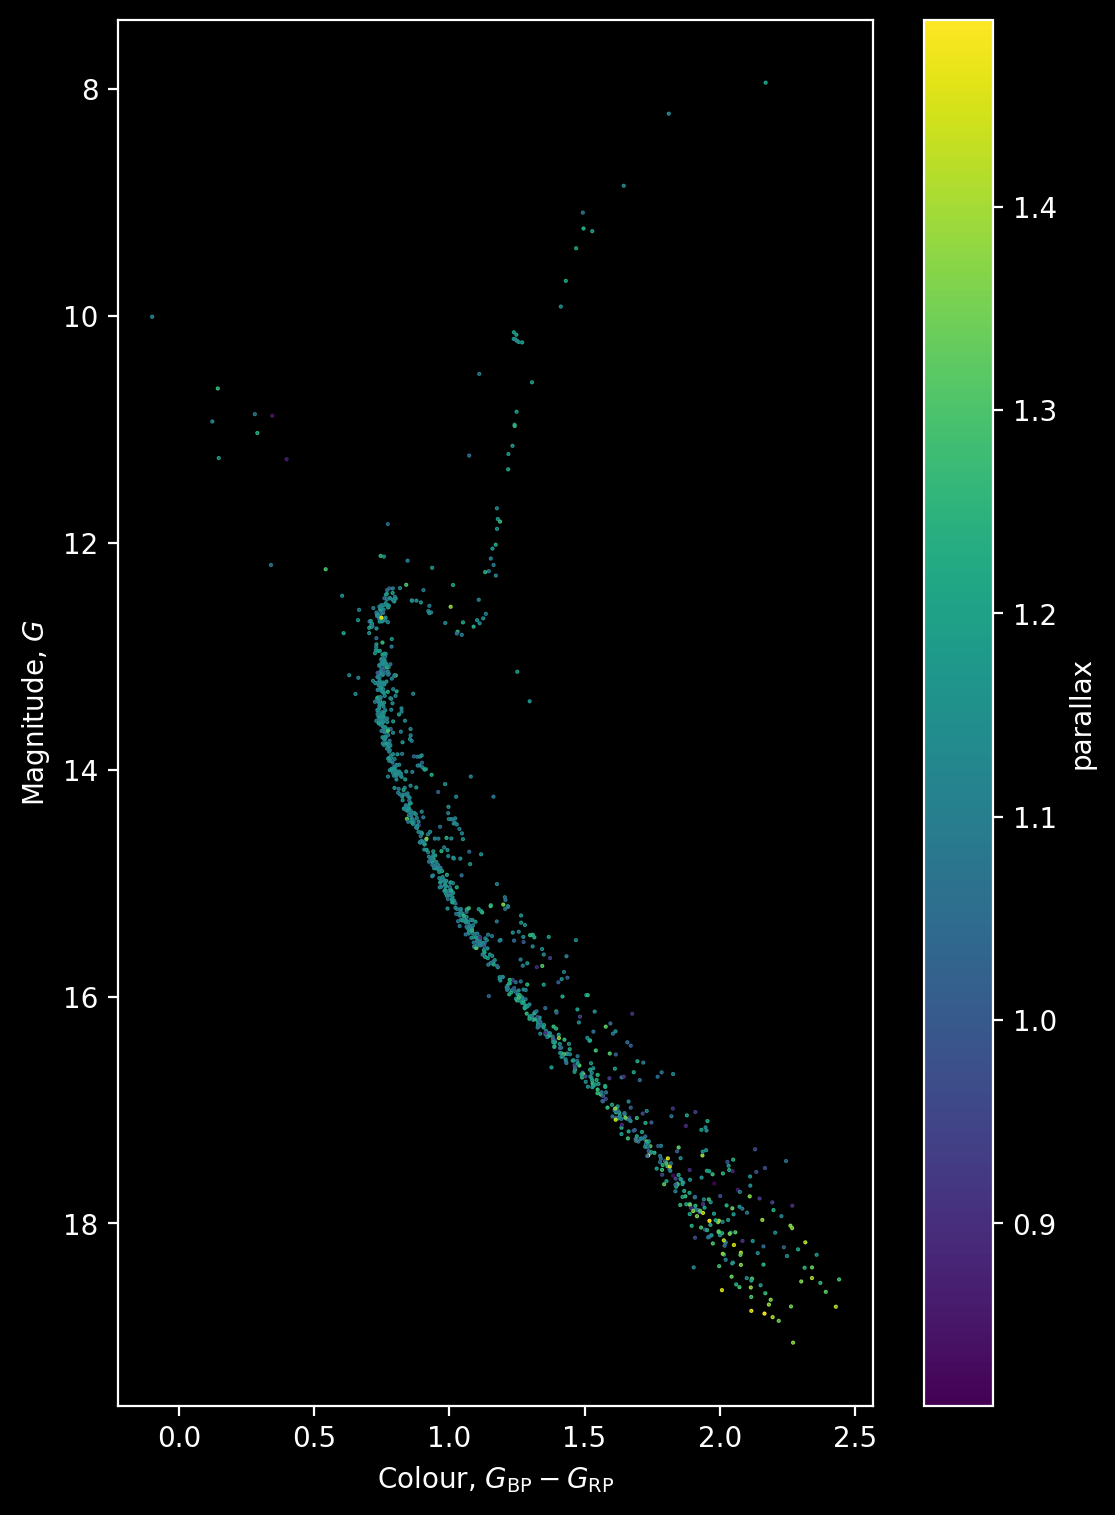

In [217]:
plot_cmd(cluster, colour_col="parallax");

## How far away is this cluster?
Let's plot up the distances for each star

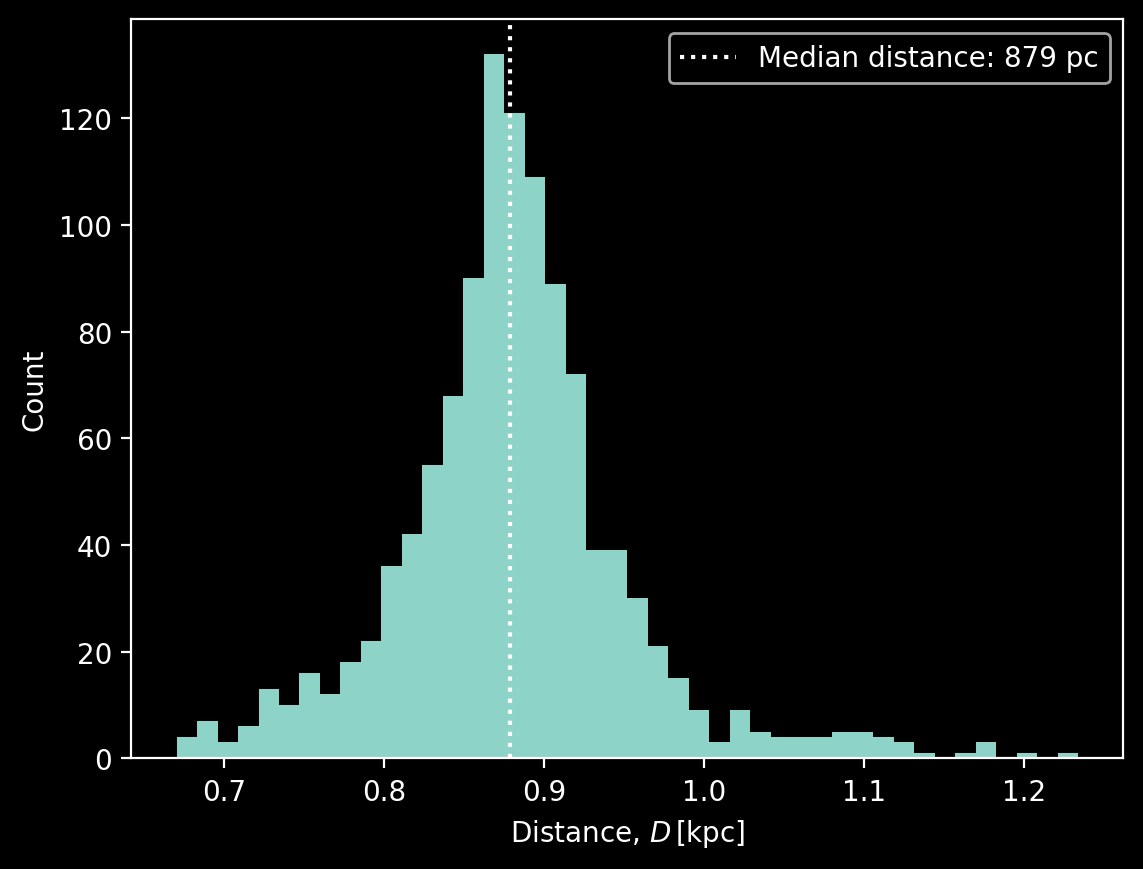

In [218]:
distances = 1 / cluster["parallax"].values * u.kpc
avg_distance = np.median(distances)

plt.hist(distances, bins="fd")
plt.axvline(avg_distance, linestyle="dotted", label=f"Median distance: {avg_distance.to(u.pc):1.0f}")
plt.xlabel(r"Distance, $D \, [\rm kpc]$")
plt.ylabel("Count")
plt.legend()
plt.show()

We've got a couple of outlying larger distances here so a median is probably better than a mean to ensure they don't have a strong effect.

The cluster is approximately ~880pc away according to our selection - this will be useful for magnitudes in a moment

## Prep MIST Isochrones
MIST isochrones using the `isochrones` package don't include the Gaia magnitudes by default. But we can convert the absolute bolometric magnitude to an apparent magnitude in each filter using bolometric correction grids and the average cluster distance.

In [219]:
grid = MISTIsochroneGrid()
bc_grid = MISTBolometricCorrectionGrid(['G', 'BP', 'RP'])

In [220]:
# copied this function from a different project
def get_apparent_mag(M_abs, distance):
    """Convert absolute magnitude to apparent magnitude
    Parameters
    ----------
    M_abs : :class:`~numpy.ndarray`
        Absolute magnitude
    distance : :class:`~astropy.units.Quantity` [length]
        Distance
    Returns
    -------
    m_app : :class:`~numpy.ndarray`
        Apparent magnitude
    """
    finite_distance = np.isfinite(distance)
    m_app = np.repeat(np.inf, len(distance))
    m_app[finite_distance] = M_abs[finite_distance] + 5 * np.log10(distance[finite_distance] / (10 * u.pc))
    return m_app

# convert the absolute magnitude to an apparent magnitude
grid.df["m_app"] = get_apparent_mag(grid.df["Mbol"].values,
                                    np.ones_like(grid.df["Mbol"].values) * avg_distance)

In [221]:
# grab the parameters from the isochrone grid and assume no extinction (see below)
bc_params = grid.df[["Teff", "logg", "feh"]].values
bc_params_plus_extinction = np.append(bc_params, np.zeros((len(bc_params), 1)), axis=1)

### Side note: Extinction
Is it reasonable for me to ignore extinction in that last cell? Let's check!

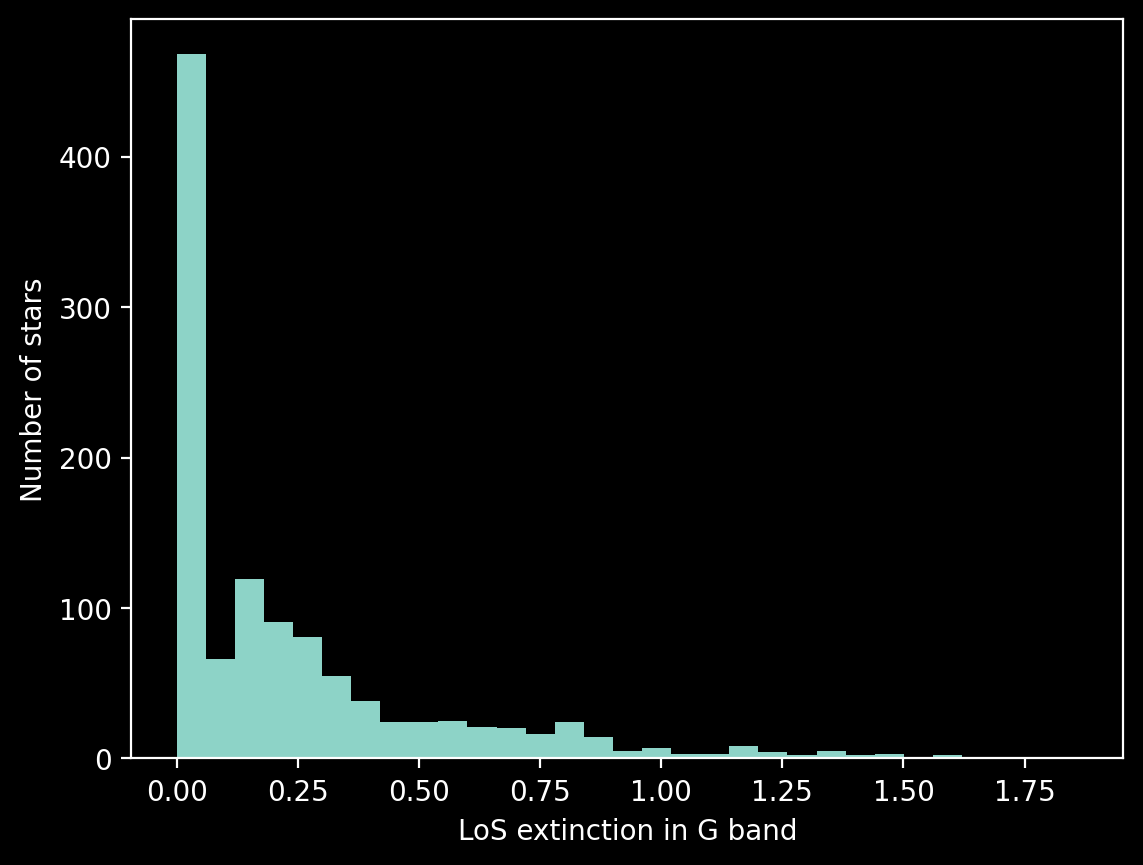

In [222]:
plt.hist(np.nan_to_num(cluster["a_g_val"], 0.0), bins="fd")
plt.xlabel("LoS extinction in G band")
plt.ylabel("Number of stars")
plt.show()

Eh okay well they're not all 0 but the values are pretty low, so this shouldn't have too strong an effect. Let's keep it in mind though when we talk about things that I fudged.

### Apply bolometric corrections
Use `isochrone`'s bolometric correction grid to get the magnitude in each relevant Gaia filter for all of the isochrones.

In [223]:
filters = ["G", "BP", "RP"]
filter_mags = grid.df["m_app"].values[:, None] - bc_grid.interp(bc_params_plus_extinction.T, filters)

for i, filt in enumerate(filters):
    grid.df[filt] = filter_mags.T[i]

### Plot example isochrones
Okay let's look at some examples. Hmm what to use for the age? Well let's just use some completely random, definitely not intentionally chosen age with different Fe/H values...

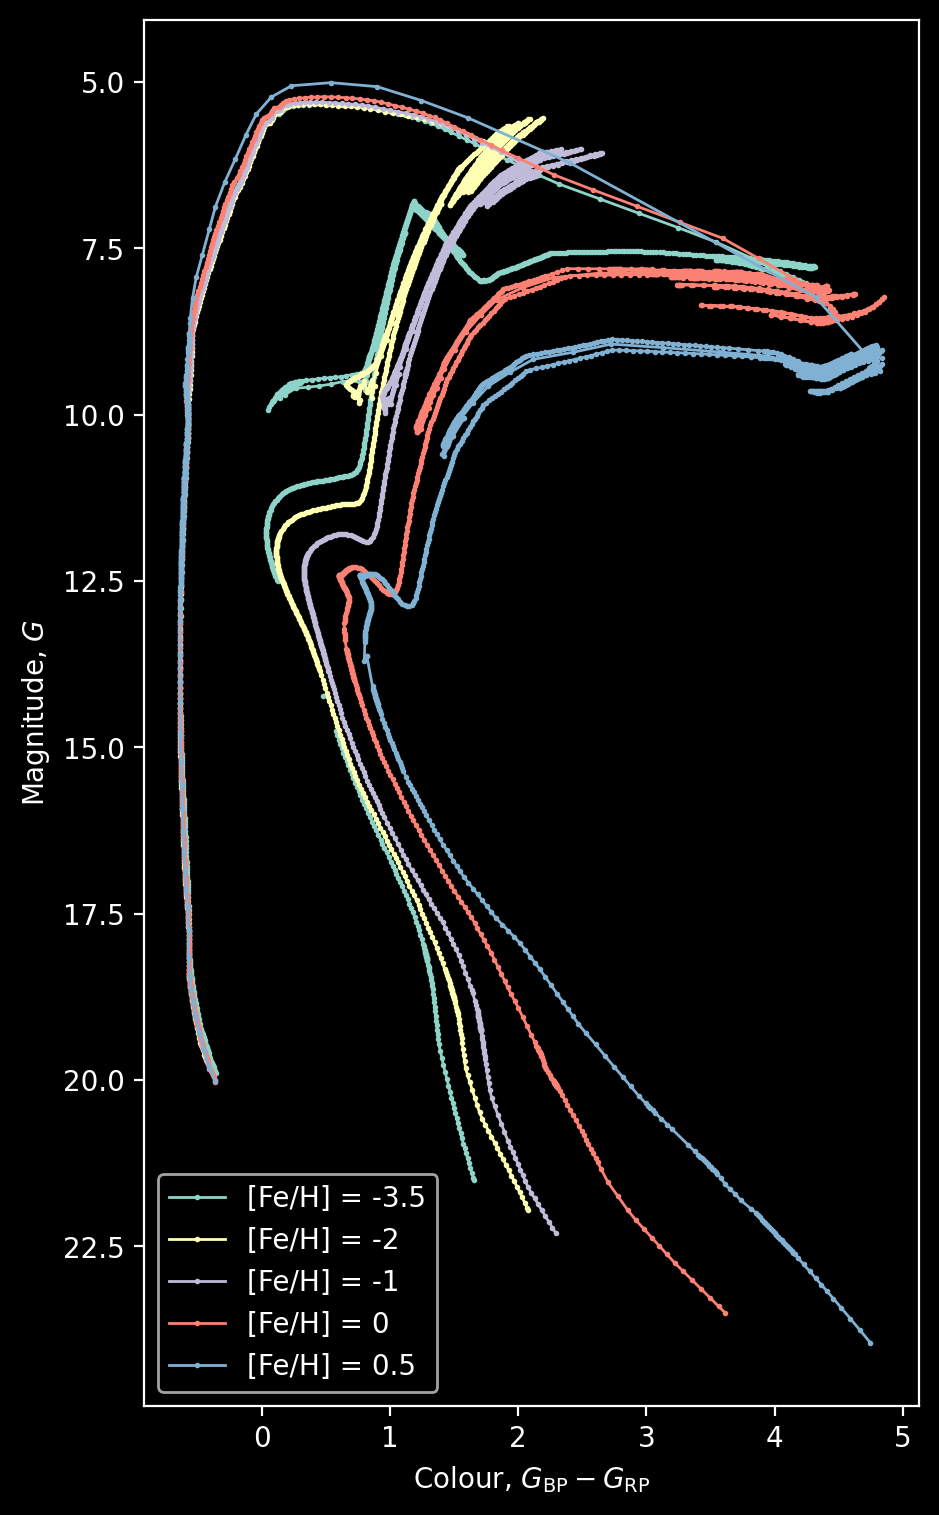

In [224]:
log_age = 9.55

plot_cmd(*[(grid.df.loc[log_age, feh], 1, f"C{i}", f"[Fe/H] = {feh}")
            for i, feh in enumerate([-3.5, -2, -1, 0, 0.5])]);

Well some of those look rather familiar ;P Now to find the best choice

## 2.1: Fit isochrones

I tried to work out how to do this with the `isochrones` package but honestly got a little lost in the docs and eventually decided to just opt for the simpler $\chi^2$ plan. In this case the method is roughly 
- Start $\chi^2$ at 0
- For each observed star in the cluster
    - Find the difference between its G mag and every isochrone point
    - Find the difference between its (BP - RP) and every isochrone point
    - Normalise the latter to account for the smaller range of values **<- this bit is important**
    - Sum the squares of the differences of the two
    - Find the minimum of these difference for this star and add to $\chi^2$ total
- Find the isochrone with the minimum $\chi^2$

Or to put it all in an equation, we want to minimise this quantity
$$ \chi^2 = \sum_{i \in {\rm cluster}} \min \{ (G_{\rm cluster, i} - G_{\rm iso, j})^2 + \left(\frac{BPRP_{\rm cluster, i} - BPRP_{\rm iso, j}}{\alpha}\right)^2 \,\, \forall j \in {\rm iso} \},\qquad \text{where } \alpha = \frac{\max{G_{\rm iso}} - \min{G_{\rm iso}}}{\max{BPRP_{\rm iso}} - \min{BPRP_{\rm iso}}} $$

### Calculate $\chi^2$

In [225]:
def isochrone_chi2(cluster, isochrone, norm=4):
    isochrone = isochrone.dropna(axis=0, subset=["G", "BP", "RP"])

    G_diff = (cluster["phot_g_mean_mag"].values[:, None] - isochrone["G"].values[None, :])**2
    bprp_diff = (((cluster["phot_bp_mean_mag"].values - cluster["phot_rp_mean_mag"].values)[:, None]
                    - (isochrone["BP"].values - isochrone["RP"]).values[None, :]) / norm)**2

    chi2 = np.min(G_diff + bprp_diff, axis=1).sum()

    # sanity check
    assert np.isfinite(chi2)

    return chi2

Let's make a grid of ages and FeH values that are in the MIST isochrones

In [226]:
feh_grid = grid.df.index.to_frame()["feh"].unique()
age_grid = grid.df.index.to_frame()["log10_isochrone_age_yr"].unique()

Then make sure we have the normalisation right

In [227]:
cluster_g_range = cluster["phot_g_mean_mag"].max() - cluster["phot_g_mean_mag"].min()
cluster_bp_rp_range = ((cluster["phot_bp_mean_mag"] - cluster["phot_rp_mean_mag"]).max()
                       - (cluster["phot_bp_mean_mag"] - cluster["phot_rp_mean_mag"]).min())
norm = cluster_g_range / cluster_bp_rp_range

And away we go!

In [228]:
chi2_grid = np.zeros((len(age_grid), len(feh_grid)))

for i, age in enumerate(age_grid):
    for j, feh in enumerate(feh_grid):
        chi2_grid[i, j] = isochrone_chi2(cluster=cluster_strict, isochrone=grid.df.loc[age, feh], norm=norm)

### Identify best fitting isochrone
We can visualise the $\chi^2$ with a nice little contour plot

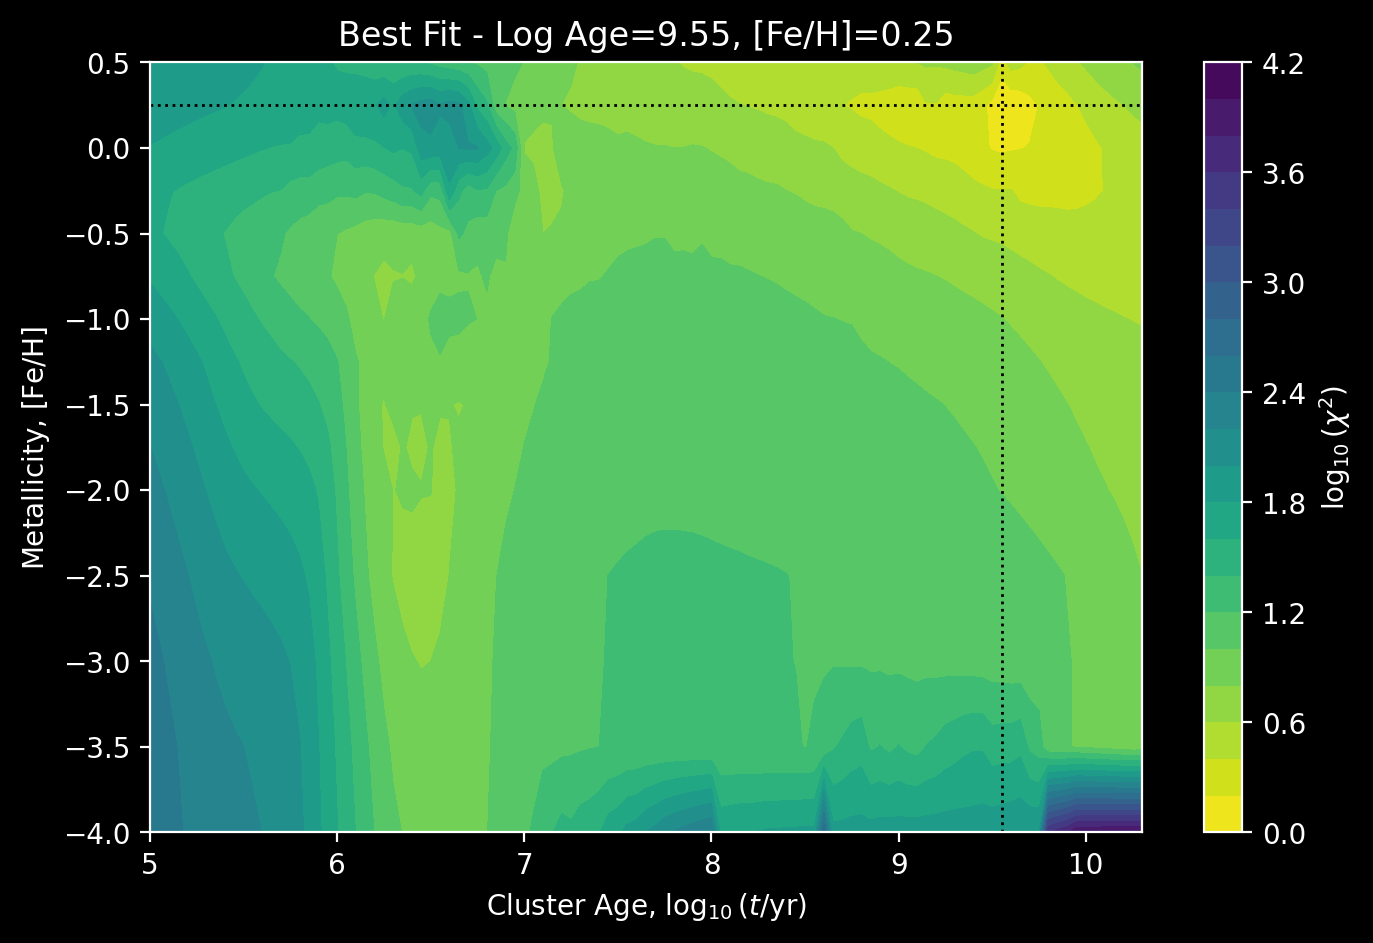

In [229]:
fig, ax = plt.subplots(figsize=(8, 5))

cont = ax.contourf(age_grid, feh_grid, np.log10(chi2_grid.T), levels=25, cmap="viridis_r")

inds = np.unravel_index(chi2_grid.argmin(), chi2_grid.shape)
best_age = age_grid[inds[0]]
best_feh = feh_grid[inds[1]]

ax.axvline(best_age, lw=1, linestyle="dotted", color="black")
ax.axhline(best_feh, lw=1, linestyle="dotted", color="black")

fig.colorbar(cont, label=r"$\log_{10}(\chi^2)$")

ax.set_xlabel(r"Cluster Age, $\log_{10}(t / {\rm yr})$")
ax.set_ylabel(r"Metallicity, $\rm [Fe/H]$")

ax.set_title(f"Best Fit - Log Age={best_age}, [Fe/H]={best_feh}")

plt.show()

In [230]:
fit_isochrone = grid.df.loc[best_age, best_feh]

### How did we do?

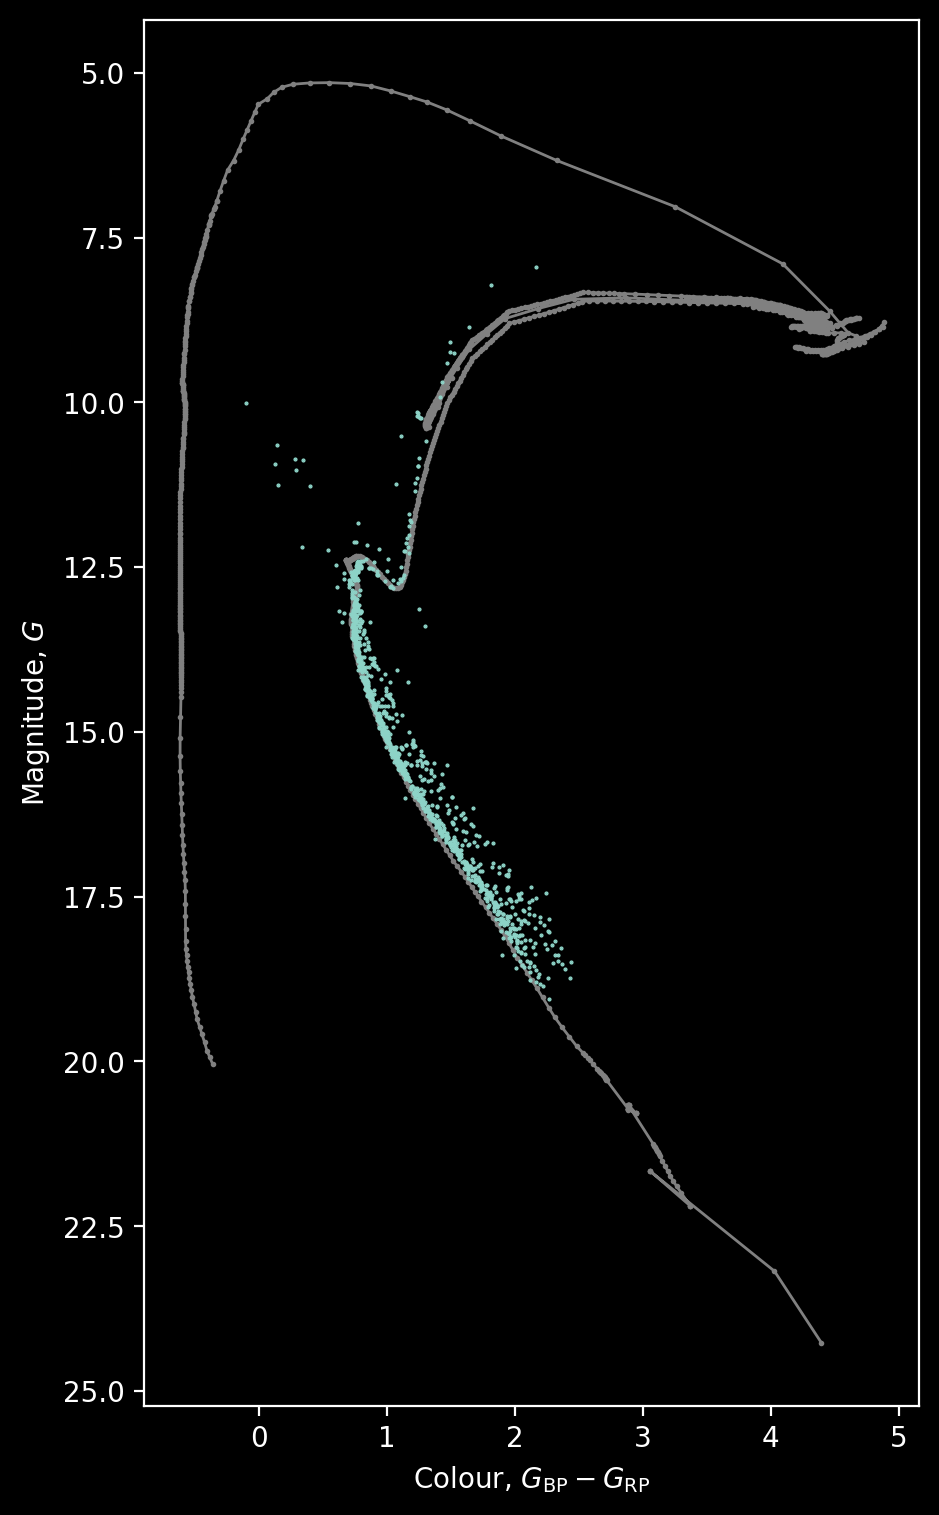

In [231]:
fig, ax = plot_cmd(cluster, fit_isochrone)

Splendid, this looks like a lovely match!!

## 2.2: Cluster Properties

### Age and Metallicity

I fit the age and metallicity using the isochrone fitting and found above values of
- Age: ~$10^{9.55}$ years 
- [Fe/H] ~ 0.25

In [232]:
best_age, best_feh

(9.55, 0.25)

### Distance
Above I found that the average distance to the cluster is approximately 880pc.

In [233]:
avg_distance.to(u.pc)

<Quantity 878.76523533 pc>

### Mean Proper Motions

In [234]:
mean_pmra = np.mean(cluster["pmra"]) * u.mas / u.yr
mean_pmdec = np.mean(cluster["pmdec"]) * u.mas / u.yr

In [235]:
def plot_joint_proper_motion(pop, gridsize=25):
    g = sns.jointplot(data=pop, x="pmra", y="pmdec", kind="kde", height=6,
                  levels=5, thresh=0.2, space=0)
    g.plot_joint(plt.hexbin, cmap="mako", gridsize=gridsize)

    for ax in [g.ax_joint, g.ax_marg_x]:
        ax.axvline(pop["pmra"].mean(), color="white", linestyle="--")

    for ax in [g.ax_joint, g.ax_marg_y]:
        ax.axhline(pop["pmdec"].mean(), color="white", linestyle="--")

    g.ax_joint.annotate(r"$\langle \mu_\alpha \rangle = $" + f"{pop['pmra'].mean():1.2f} mas/yr\n"\
                        + r"$\langle \mu_\delta \rangle = $" + f"{pop['pmdec'].mean():1.2f} mas/yr",
                        xy=(0.98, 0.98), ha="right", va="top", xycoords="axes fraction", fontsize="large")

    g.ax_joint.set_xlabel(r"RA Proper Motion, $\mu_\alpha \, [\rm{mas / yr}]$")
    g.ax_joint.set_ylabel(r"Dec Proper Motion, $\mu_\delta \, [\rm{mas / yr}]$")

    plt.show()

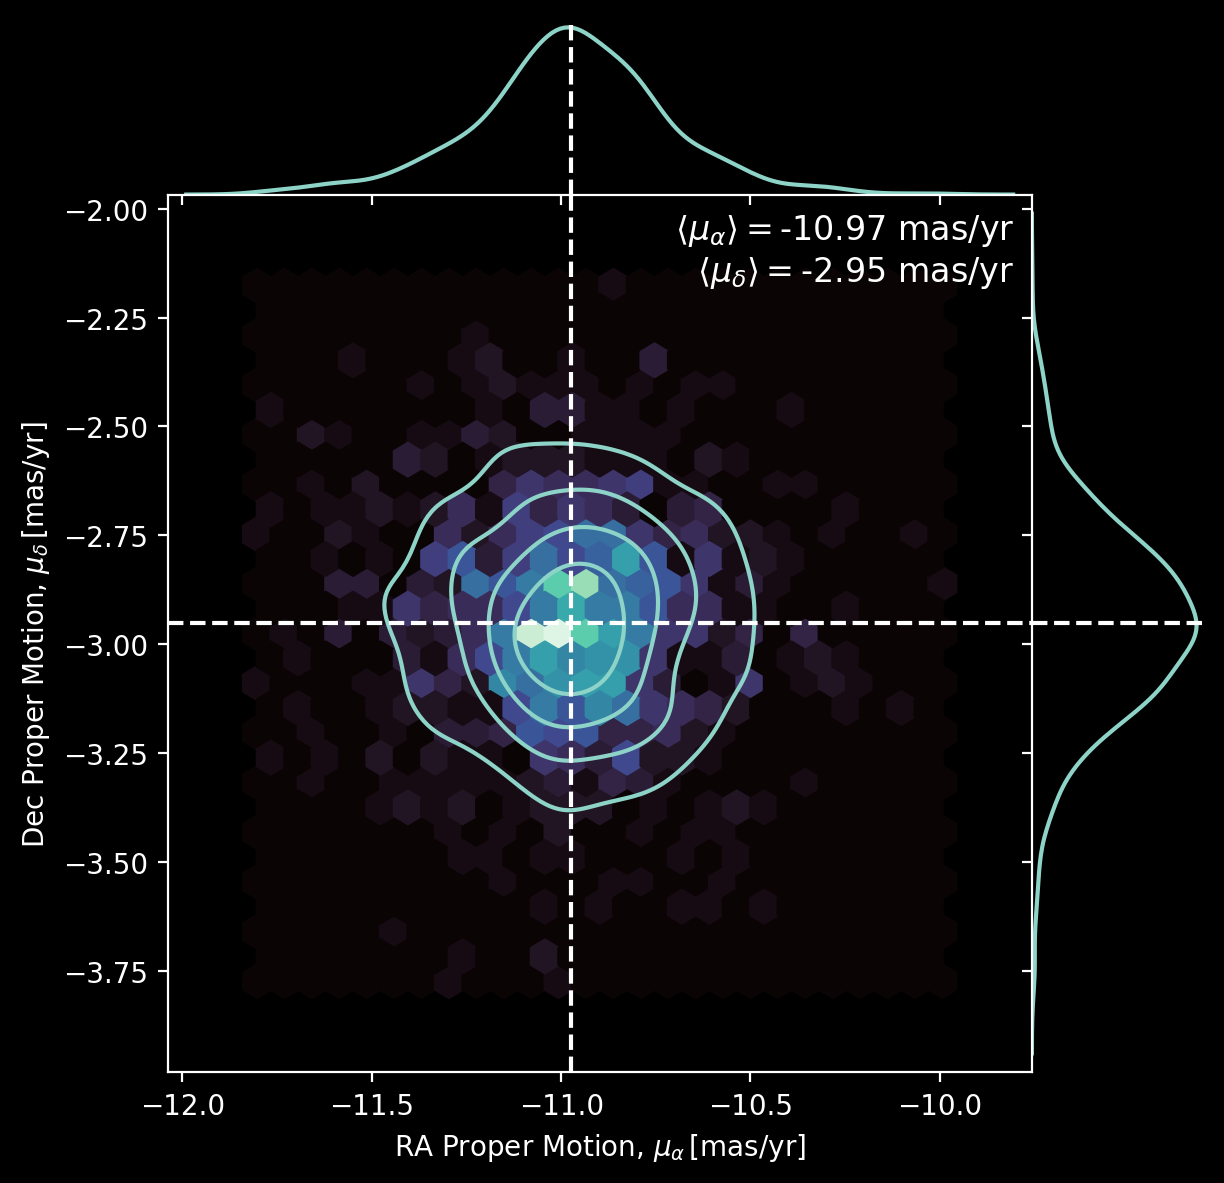

In [236]:
plot_joint_proper_motion(cluster)

So the distributions are pretty well behaved with clear symmetric peaks, the means in the plot annotations give the mean motion.

### Mean parallax

In [237]:
mean_parallax = np.mean(cluster["parallax"]) * u.mas
mean_parallax

<Quantity 1.14324701 mas>

### Radius

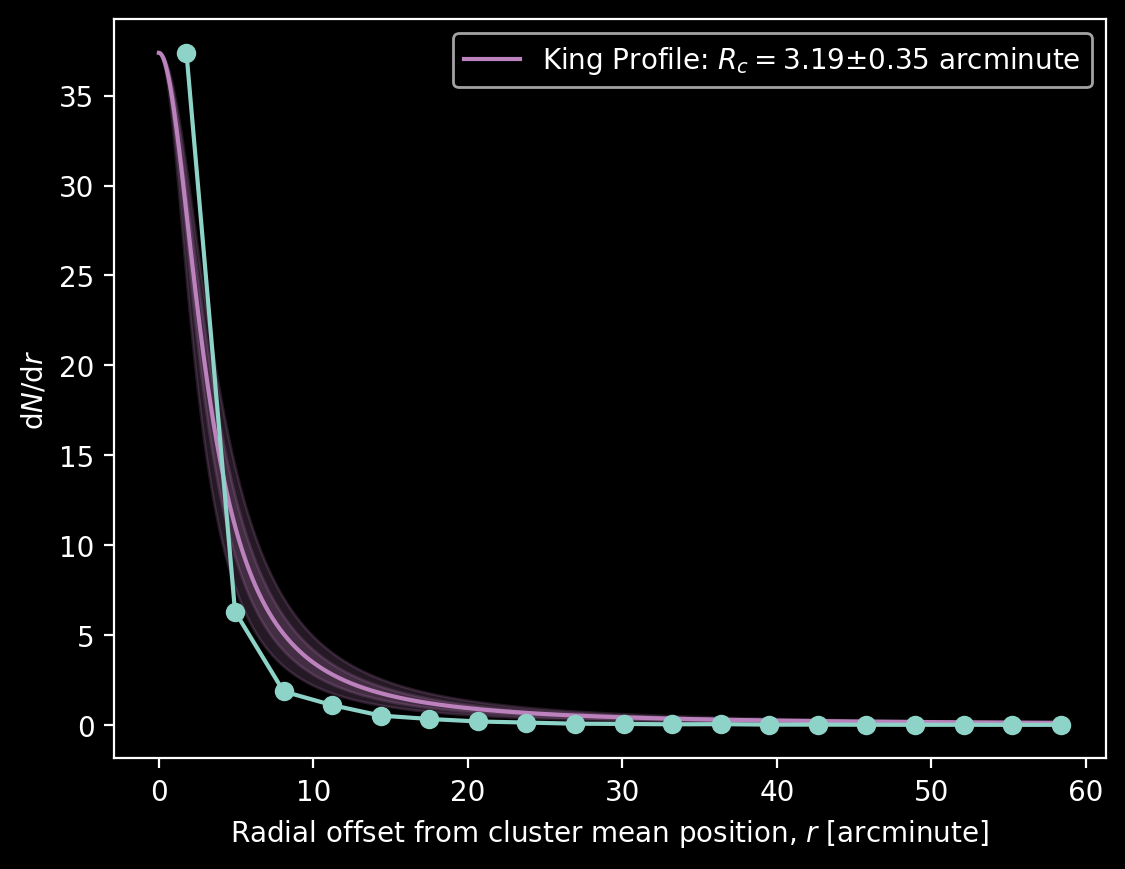

In [238]:
for pop in [cluster, cluster_strict, field]:
    pop["radial_offset"] = (np.sqrt((pop["ra"] - pop["ra"].mean())**2
                                    + (pop["dec"] - pop["dec"].mean())**2).values * u.deg).to(u.arcminute).value

h_r, bins_r = np.histogram(cluster["radial_offset"], bins="fd")
bin_centres_r = (bins_r[1:] + bins_r[:-1]) / 2

surf_dens_prof = h_r / bin_centres_r**2
plt.plot(bin_centres_r, surf_dens_prof, marker="o")


n0 = max(surf_dens_prof)
def king_profile(r, Rc):
    profile = n0 / (1 + (r / Rc)**2)
    return profile

popt, pcov = curve_fit(king_profile, bin_centres_r, surf_dens_prof)
Rc = popt[0]
stddev = np.sqrt(pcov[0][0])

x_range = np.linspace(0, np.max(bin_centres_r), 10000)
plt.fill_between(x_range, king_profile(x_range, Rc - 2 * stddev),
                 king_profile(x_range, Rc + 2 * stddev), color="C7", alpha=0.2)
plt.fill_between(x_range, king_profile(x_range, Rc - stddev),
                 king_profile(x_range, Rc + stddev), color="C7", alpha=0.2)

plt.plot(x_range, king_profile(x_range, Rc), color="C7", zorder=1,
         label=r"King Profile: $R_c = $" + f"{Rc:1.2f}" + r"$\pm$" + f"{stddev:1.2f} arcminute")

plt.legend()

plt.xlabel("Radial offset from cluster mean position, $r$ [arcminute]")
plt.ylabel(r"$\mathrm{d}N/\mathrm{d}r$")

plt.show()

### Mass
For the mass we can get the closest isochrone point to each star and total the mass of these points as a simple estimate of the cluster mass

In [239]:
def get_cluster_masses(cluster, isochrone, norm=4):
    isochrone = isochrone.dropna(axis=0, subset=["G", "BP", "RP"])

    G_diff = (cluster["phot_g_mean_mag"].values[:, None] - isochrone["G"].values[None, :])**2
    bprp_diff = (((cluster["phot_bp_mean_mag"].values - cluster["phot_rp_mean_mag"].values)[:, None]
                    - (isochrone["BP"].values - isochrone["RP"]).values[None, :]) / norm)**2

    return isochrone["mass"].values[np.argmin(G_diff + bprp_diff, axis=1)]

In [240]:
cluster_masses = get_cluster_masses(cluster, fit_isochrone, norm=norm)
cluster_mass = cluster_masses.sum() * u.Msun
cluster_mass

<Quantity 1088.54737203 solMass>

## 2.3: The funky stuff

I added some masks to try to pull out anything that looks like it might be a binary, a blue straggler or maybe a sub-giant. These masks are one of the few manual things in this notebook and wouldn't apply to other clusters, but should be quick to change by playing with the limits I set.

In [241]:
def get_smallest_distances(cluster, isochrone, norm=4):
    isochrone = isochrone.dropna(axis=0, subset=["G", "BP", "RP"])

    G_diff = (cluster["phot_g_mean_mag"].values[:, None] - isochrone["G"].values[None, :])**2
    bprp_diff = (((cluster["phot_bp_mean_mag"].values - cluster["phot_rp_mean_mag"].values)[:, None]
                    - (isochrone["BP"].values - isochrone["RP"]).values[None, :]) / norm)**2

    return np.min(G_diff + bprp_diff, axis=1)

def get_binary_mask(pop):
    ms_isochrone = fit_isochrone.iloc[30:200].dropna(axis=0, subset=["G", "BP", "RP"])
    interp_iso = interp1d(ms_isochrone["G"].values, ms_isochrone["BP"].values - ms_isochrone["RP"].values)
    G_range = np.linspace(12.5, 19, 10000)
    bprp = interp_iso(G_range)
    
    G_diff = (cluster["phot_g_mean_mag"].values[:, None] - G_range[None, :])**2
    bprp_diff = (((cluster["phot_bp_mean_mag"].values - cluster["phot_rp_mean_mag"].values)[:, None] - bprp[None, :]) / norm)**2
    dist_to_ms = np.min(G_diff + bprp_diff, axis=1)
    
    # apply different distance limits in different magnitude ranges (this is very hacky)
    lims = [(13.5, 15.5, 2e-4), (15, 17.5, 0.001), (17, 18.75, 0.002)]
    mask = np.repeat(False, len(pop))
    for mag_low, mag_high, dist in lims:
        mask = mask | ((pop["phot_g_mean_mag"] > mag_low) & (pop["phot_g_mean_mag"] <= mag_high) & (dist_to_ms > dist))

    return mask

def get_blue_straggler_mask(pop):
    if not "dist_to_iso" in pop:
        pop["dist_to_iso"] = get_smallest_distances(pop, fit_isochrone.iloc[60:1000], norm=norm)

    return (pop["phot_bp_mean_mag"] - pop["phot_rp_mean_mag"] < 0.6) & (pop["dist_to_iso"] > 0.004)

def get_sub_sub_giants(pop):
    if not "dist_to_iso" in pop:
        pop["dist_to_iso"] = get_smallest_distances(pop, fit_isochrone.iloc[60:1000], norm=norm)

    return (pop["phot_bp_mean_mag"] - pop["phot_rp_mean_mag"] > 1.2) & (pop["phot_g_mean_mag"] > 13) & (pop["phot_g_mean_mag"] < 14) & (pop["dist_to_iso"] > 0.004)

I pulled out the binaries by taking anything that was "far" from the isochrone but still quick dim. This picked up a lot of the "binary sequence" that tracks along above the main sequence, though not quite the top of it. For the blue stragglers I just took the blue stars that were far from the isochrone (ignoring the later EEPs). Lastly the sub-sub-giants I took the red middling brightness stars far from the isochrone to pull them out, there only seem to be two here.

I tried this with both `cluster` and `cluster_strict` and the plot looks pretty similar, so I am fairly confident that most of these are cluster members.

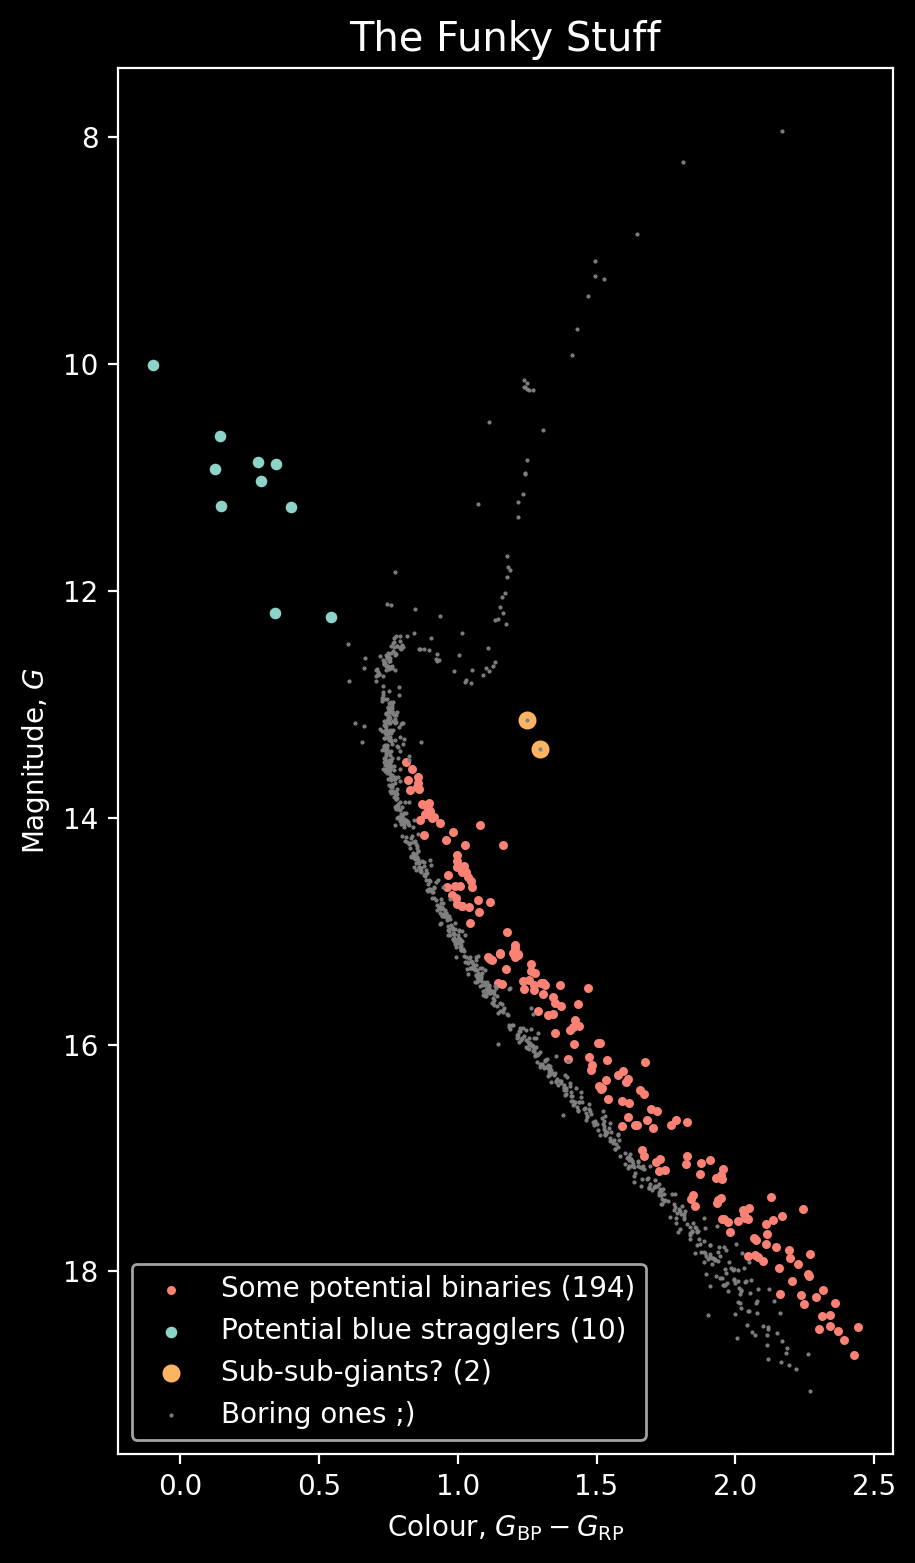

In [242]:
binaries = get_binary_mask(cluster)
bs = get_blue_straggler_mask(cluster)
ssg = get_sub_sub_giants(cluster)
fig, ax = plot_cmd((cluster[binaries], 5, "C3", f"Some potential binaries ({binaries.sum()})"),
         (cluster[bs], 10, "C0", f"Potential blue stragglers ({bs.sum()})"),
         (cluster[ssg], 30, "C5", f"Sub-sub-giants? ({ssg.sum()})"),
         (cluster[~(binaries | bs)], 0.25, "grey", "Boring ones ;)"), show=False)
ax.set_title("The Funky Stuff", fontsize="x-large")

plt.show()

We can estimate a rough binary fraction based on my mask:

In [243]:
binary_fraction = binaries.sum() / len(cluster)
f"{binary_fraction:1.2f}"

'0.17'

I also wasn't too sure about the two sub-sub-giants but it seems that at least [Mathieu+2003](https://ui.adsabs.harvard.edu/abs/2003AJ....125..246M/abstract) marked these two as sub-sub-giants way back in 2003!

## 2.4: Discussion

### Interesting properties

I think the main interesting property of this cluster is that it is very old. I estimate that the age is around 3.6 Gyr and hence we see that all the massive stars have since died and so the most massive star in the cluster is only slightly more massive than the Sun.

### Literature Comparisons

As a reminder, this is what I find for the cluster properties:

In [244]:
properties = best_age, best_feh, avg_distance.to(u.pc), (mean_pmra, mean_pmdec), mean_parallax, Rc * u.arcminute, cluster_mass, len(cluster)
labels = ["Log(age / yr)", "[Fe/H]", "Distance", r"Mean proper motion", "Mean Parallax", "Radius", "Mass", "Total members"]

for prop, label in zip(properties, labels):
    if isinstance(prop, tuple):
        print(label + f" = ({prop[0].value:1.2f}, {prop[1].value:1.2f}) {prop[0].unit}")
    else:
        print(label + f" = {prop:1.2f}")

Log(age / yr) = 9.55
[Fe/H] = 0.25
Distance = 878.77 pc
Mean proper motion = (-10.97, -2.95) mas / yr
Mean Parallax = 1.14 mas
Radius = 3.19 arcmin
Mass = 1088.55 solMass
Total members = 1131.00


In [245]:
len(field) / field["radial_offset"].max()**2

1.0953764052509032

[Fan+1996](https://ui.adsabs.harvard.edu/abs/1996AJ....112..628F/abstract) estimate an age of 4.0 Gyr and metallicity of -0.1, both close to what I estimate (slightly older and slightly more metal rich respectively). They estimate 16% of systems are binaries (very close to my 17%!). They also make estimates for the extinction (0.015-0.052) so my assumption of 0 isn't quite right as expected.

[Richer+1998](https://ui.adsabs.harvard.edu/abs/1998ApJ...504L..91R/abstract) estimated the cluster age to 4.0 Gyr additionally, still close to my estimate. They also found that the cluster mass should be around 1080 Msun, very close to my attempt!!

I also found this paper by [Davenport & Sandquist 2010](https://ui.adsabs.harvard.edu/abs/2010ApJ...711..559D/abstract), name seems familiar for some reason :D This paper found a binary fraction of 26% ± 6%, marginally higher than what I got. The paper found a core radius of 8.24' ± 0.60', which is rather larger than my estimate (though early papers do calculate the radius to be slightly smaller - e.g. [Bonatto & Bica 2003](https://www.aanda.org/articles/aa/pdf/2003/26/aah4157.pdf) find 4.86'). They found the total number of members in the cluster to be around 1385 ± 67, slightly higher than my estimate of 1138.

[Ghosh+2022](https://ui.adsabs.harvard.edu/abs/2022JPhCS2214a2009G/abstract) is a recent paper that I found using Gaia EDR3 data. They find that the log(age) is around 9.63, the metallicity around 0.01865 and the proper motion around (−10.96, −2.90). These are all in fairly close agreement, I can imagine that if I interpolated the isochrones and could access a finer set of metallicities that I may get closer in agreement. They find a distance of 872 ± 50 pc, with comfortably agrees with my estimate.

### Obvious problems with my analysis

There are _many_ obvious problems with this analysis, here are just some of them. I was honestly surprised that I was close on so many of the properties given how dodgy some of this was!

**Extinction**: I completely ignored extinction in my estimates. I _did_ check how big an effect it should have and the extinction values seem to be mostly negligible but I can imagine this being a problem in reality since it will shift all of the magnitudes around.

In particular, if we plot up the CMD again but colour by the extinction values you can see that lots of the things that are hanging around above the main sequence actually have nonzero extinction that may affect things.

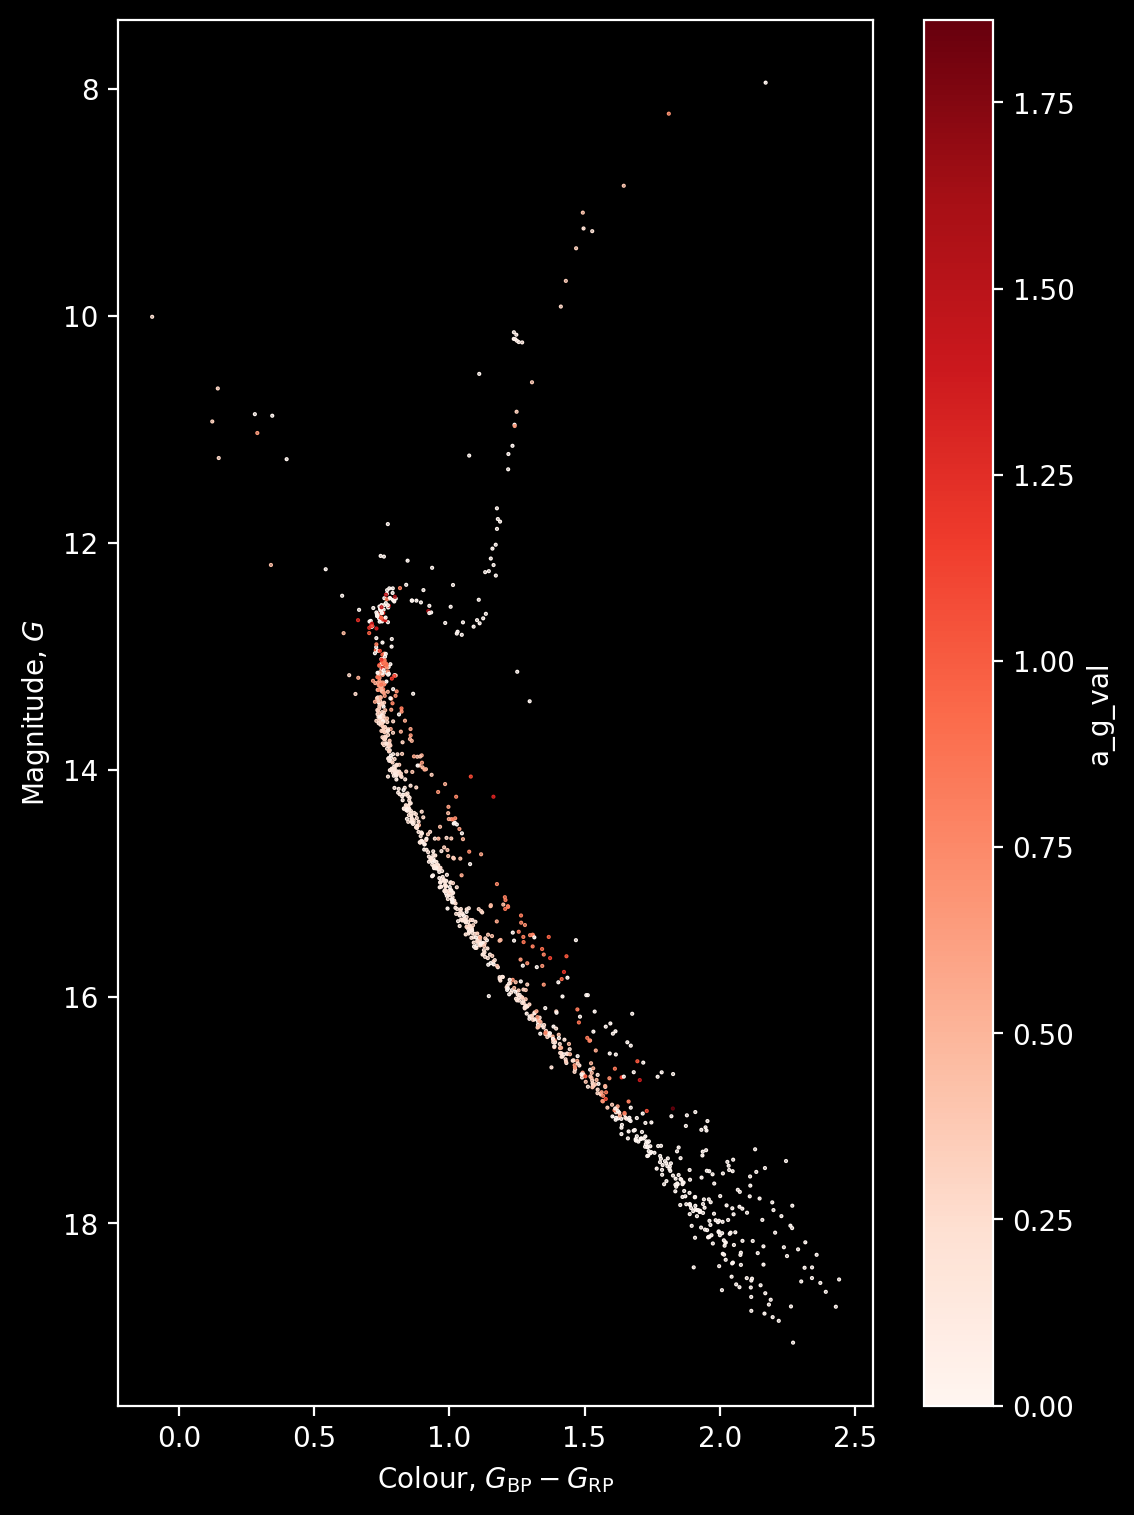

In [246]:
plot_cmd(cluster, colour_col="a_g_val", cmap="Reds");

**Uncertainties and Error Bars**: I ignored the `ra_error`, `pmdec_error` etc columns (once I had made my initial cuts to make sure that the measurements weren't awful). I'm interested to know how to fold this into a GMM, I feel like it should be possible but I wasn't entirely sure how to accomplish it easily. 

I was thinking that maybe I could do some bootstrapping based on the errors and create a GMM for each sample and then combine the probabilities in each to account for this. I can imagine that could be useful for identifying sources that we should be less certain about at least.

**Isochrone fitting**: There are various problems with the way that I fit the isochrone. Firstly I just did a simple $\chi^2$ rather than something smarter like some sort of MCMC sampling. But I don't think that would have made much difference in this case since I had quite a coarse grid of isochrones from MIST. More useful would have been to interpolate between the curves to get a more precise estimate of the age and metallicity of the cluster. With more time I think this would be fairly reasonable to do with `isochrones`.

### Cluster membership vs. mass
Where am I most certain of cluster membership in relation to the mass of each member? Let's plot it up! Note that below I am plotting the probability of **non**-membership to make the log scale work nicely.

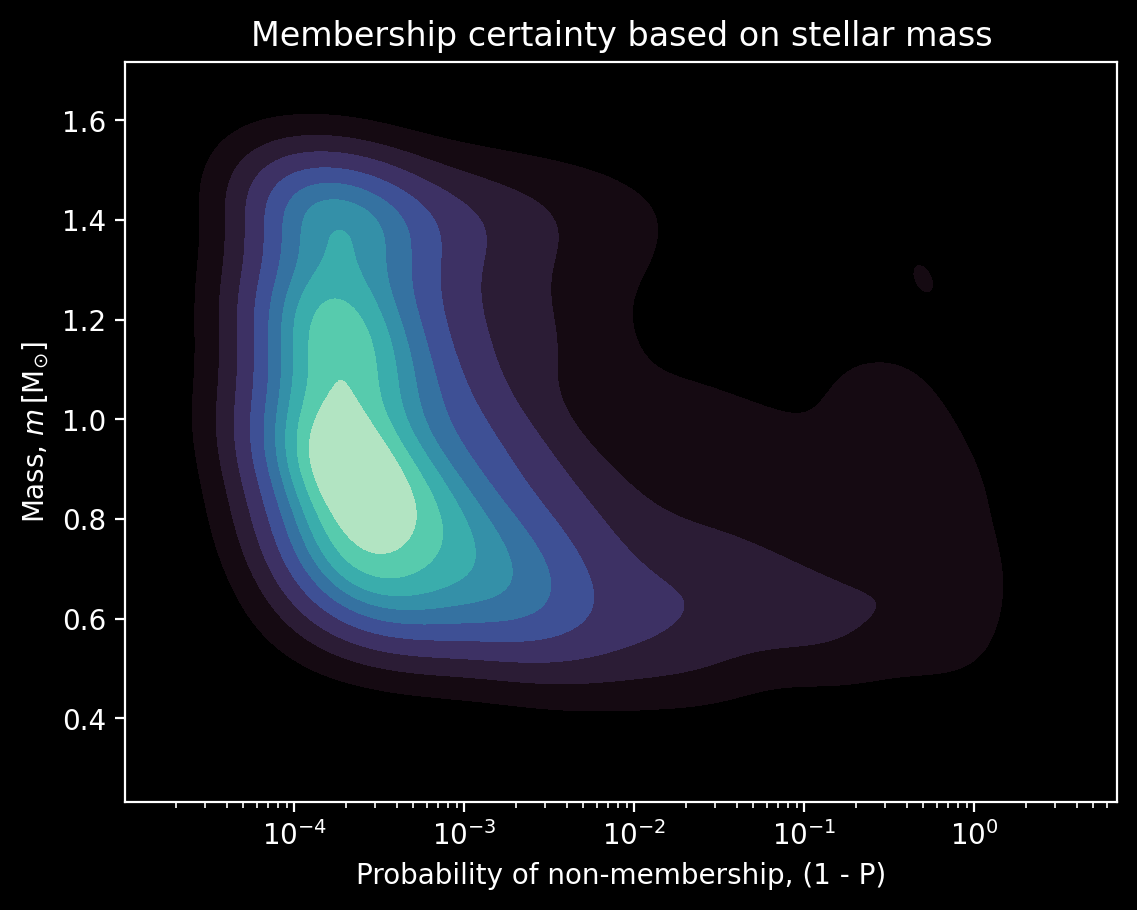

In [247]:
prob_limit = 1e-1
ax = sns.kdeplot(x=(1 - probs[probs > prob_limit]),
                 y=get_cluster_masses(r[quality_cut][probs > prob_limit], fit_isochrone.iloc[30:1000], norm=norm),
                 log_scale=(True, False), fill=True, cmap="mako")
ax.set_xlabel("Probability of non-membership, (1 - P)")
ax.set_ylabel(r"Mass, $m \, [\rm M_{\odot}]$")
ax.set_title("Membership certainty based on stellar mass")
plt.show()

We can see from this that whilst there are a range of probabilities for the low mass stars, the higher mass stars we are generally very certain of their membership. I'm not certain why but I guess the higher mass stars are closer to the turn-off which has a more complex shape to constrain than the main sequence? Perhaps it could also be something to do with mass segregation where the ones near the centre (and hence more certain) tend to be more massive?

# Summary

Here's a final CMD of my cluster members and best fit isochrones as well as cluster properties for convenience so you don't have to trawl through this notebook. It's crazy how fast these tools like `astroquery` and `isochrones` make this, you can run this whole notebook in around a minute!! This homework was lots of fun, thanks :)

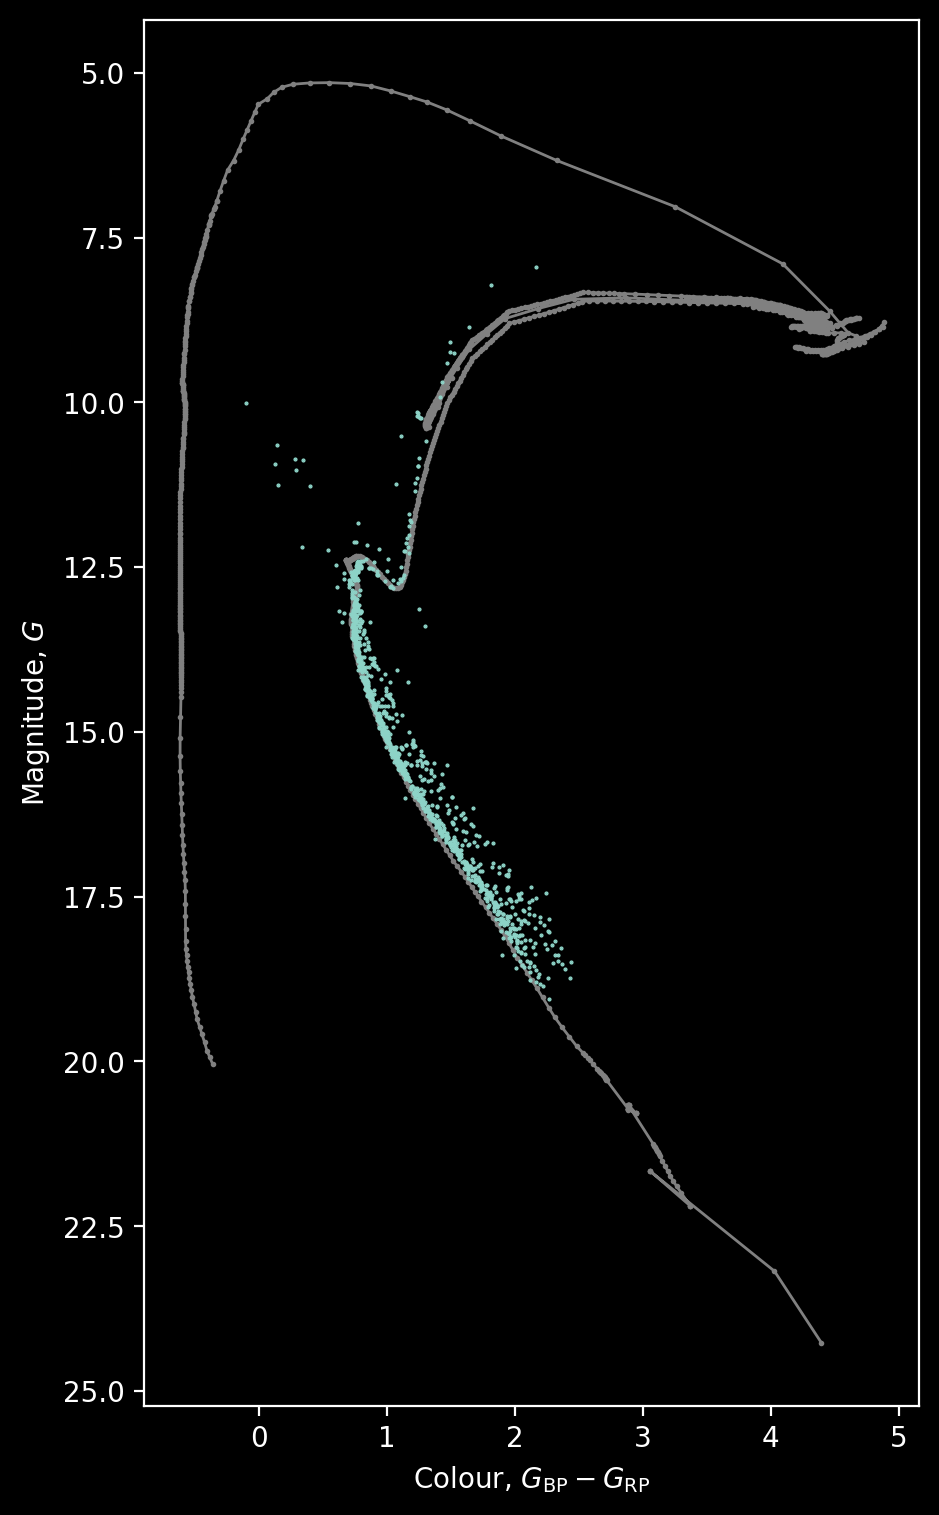

In [248]:
plot_cmd(cluster, fit_isochrone);

In [249]:
properties = best_age, best_feh, avg_distance.to(u.pc), (mean_pmra, mean_pmdec), mean_parallax, Rc * u.arcminute, cluster_mass, len(cluster)
labels = ["Log(age / yr)", "[Fe/H]", "Distance", r"Mean proper motion", "Mean Parallax", "Radius", "Mass", "Total members"]

for prop, label in zip(properties, labels):
    if isinstance(prop, tuple):
        print(label + f" = ({prop[0].value:1.2f}, {prop[1].value:1.2f}) {prop[0].unit}")
    else:
        print(label + f" = {prop:1.2f}")

Log(age / yr) = 9.55
[Fe/H] = 0.25
Distance = 878.77 pc
Mean proper motion = (-10.97, -2.95) mas / yr
Mean Parallax = 1.14 mas
Radius = 3.19 arcmin
Mass = 1088.55 solMass
Total members = 1131.00


In [250]:
notebook_end = time.time()
f"{notebook_end - notebook_start:1.2f}s"

'47.67s'